In [1]:
import pandas as pd
import numpy as np 
from pylab import *
import ast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
# from yahoo_finance import Share
from pandas_datareader import data, wb

from sklearn import metrics
from sklearn.cluster import KMeans
# from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

import math
import scipy.stats as s

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [2]:
def sub_data(filename_data, filename_symbology, dir_pickle, start_date, end_date, query_attribute, query_criteria,
             include_avg):
    query_criteria_filename = '-'.join(query_criteria[:3])
    pickle_name = dir_pickle +'pickle_sentiment_'+ start_date +'_'+ end_date +'_'+ query_attribute + '_' + query_criteria_filename +'.p'
    try: 
        data = pd.read_pickle(pickle_name)
        print("Loaded from pre-created pickle")
    except:
        print("Subsampling data from csv")
        # try to read first from pickle
        # read csv
        data = pd.read_csv(filename_data)
        # merge with symbology csv for additional info
        data_symbology = pd.read_csv(filename_symbology)
        # convert headers to uppercase for ease of use
        data_symbology.columns = [x.upper() for x in data_symbology.columns]
        data = pd.merge(data, data_symbology, left_on='SYMBOL', right_on='SYMBOL', how = "left")
        # perform filter query based on parameters
        data = data[data[query_attribute].isin(query_criteria)]
        # convert timestamps to datetime objects
        data['DATE'] = data['TIMESTAMP_UTC'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
            # datetime.strftime('%x')   only keep date but type is string   09/12/10
        data['DATE'] = data['DATE'].apply(lambda x: x.strftime('%x'))
            # pd.to_datetime()   change string to datetime type   2010-10-20
        data['DATE'] = data['DATE'].apply(lambda x: pd.to_datetime(x))
        # query between start and end date
        data = data[(data['DATE'] > start_date) & (data['DATE'] < end_date)]
        
        # remove columns which contain 'avg' in column name
        if include_avg == False:
            avg_cols = [col for col in data.columns if 'AVG' in col]
            data.drop(avg_cols,inplace=True,axis=1)
        # save as pickle
        data.to_pickle(pickle_name)
    # return dataframe
    return data

# function to return historical finance data
# takes a list of ticker symbols
# if sum_data_frame is true -> create a summed value to form an indic (combine data frame together for diff companies)
# else create a concatenated dataframe
def get_data_finance(source, symbols, start_date, end_date, dir_pickle, sum_data_frame, sum_symbol):
    symbols_filename = '-'.join(symbols[:3])
    pickle_name = dir_pickle+'pickle_finance_'+str(sum_data_frame)+start_date+'_'+end_date+'_'+symbols_filename+'.p'
    try: 
        data_finance = pd.read_pickle(pickle_name)
        print("Loaded from pre-created pickle")
    except:
        print("Scraping and saving data from Yahoo")
        # get finance data using pandas data reader
        print("0: " + symbols[0])
        # create df from first symbol
        try:
            data_finance = data.DataReader(symbols[0], source, start_date, end_date)
            # convert headers to uppercase for ease of use
            data_finance.columns = [x.upper() for x in data_finance.columns]
            if sum_data_frame:
                data_finance['SYMBOL'] = sum_symbol
            else:
                data_finance['SYMBOL'] = symbols[0]
        except: 
            print("Unable to retrieve data for: " + symbols[0])
            
        # loop through remaining symbols and either add or concatenate
        i = 1
        for symbol in symbols[1:]:
            print(str(i) + ": " + symbol)
            i += 1
            try:
                symbol_finance = data.DataReader(symbol, source, start_date, end_date)
                # convert headers to uppercase for ease of use
                symbol_finance.columns = [x.upper() for x in symbol_finance.columns]
                # sum dataframes
                if sum_data_frame:
                    symbol_finance['SYMBOL'] = sum_symbol
                    data_finance = data_finance + symbol_finance
                    data_finance['SYMBOL'] = sum_symbol
                # vertically concat dataframes
                else:
                    symbol_finance['SYMBOL'] = symbol
                    data_finance = pd.concat([data_finance, symbol_finance], axis=0)
            except: 
                print("Unable to retrieve data for: " + symbol)
        # reset index (optional)
        data_finance.reset_index(level=0, inplace=True)
        # convert headers to uppercase for ease of use
        data_finance.columns = [x.upper() for x in data_finance.columns]
            # Sort by date
#         data_finance = data_finance.sort_values(['DATE'], ascending=[True])
        data_finance.to_pickle(pickle_name)
    # return as dataframe
    return data_finance  

#preprocess sentiment data with additional columns for:
def preprocess_data_sentiment(df):
    df['CHANGED_BULL_INTENSITY'] = df['BULLISH_INTENSITY'].diff()
    df['CHANGED_BEAR_INTENSITY'] = df['BEARISH_INTENSITY'].diff()
    df['CHANGED_BULL_MINUS_BEAR'] = df['BULL_MINUS_BEAR'].diff()
    # log bull messages
    df['LOG_BULL_RETURN'] = np.log(1+df['BULL_SCORED_MESSAGES']).diff()
    # log bear messages
    df['LOG_BEAR_RETURN'] = np.log(1+df['BEAR_SCORED_MESSAGES']).diff()
    # log bullishness
    df['LOG_BULL_BEAR_RATIO'] = np.log(1 + df['BULL_SCORED_MESSAGES']) - np.log(1 + df['BEAR_SCORED_MESSAGES'])
    # log bullishness return
    df['LOG_RATIO_RETURN'] = df['LOG_BULL_BEAR_RATIO'].diff()
    # TISf
    df['TIS'] = (1+df['BULL_SCORED_MESSAGES'])/(1+ df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES'])
    # RTISf
    df['RTIS'] = ((1+df['BULL_SCORED_MESSAGES'])/(1+ df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES'])).pct_change()
    # diff in total scanned messages
    df['TOTAL_SCANNED_MESSAGES_DIFF'] = df['TOTAL_SCANNED_MESSAGES'].diff()
    # diff in total sentiment messages
    df['TOTAL_SENTIMENT_MESSAGES_DIFF'] = np.log(1 + df['BULL_SCORED_MESSAGES']+df['BEAR_SCORED_MESSAGES']).diff()
    return df
    
def preprocess_data_finance(df):
    # log return based on Adj close price
    df['LOG_RETURN'] = np.log(df['ADJ CLOSE']) - np.log(df['ADJ CLOSE'].shift(1))
    # volatitility
    df['VOLATILITY'] = df['HIGH'] - df['LOW']
    # difference in volume
    df['LOG_VOLUME_DIFF'] = np.log(df['VOLUME']).diff()
    
    
def merge_sentiment_finance(data_sentiment, data_finance, with_symbol, to_sentiment, to_finance):
    if with_symbol:
        if to_finance and to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE', 'SYMBOL'], how='inner')
        if to_finance:
            return pd.merge(data_sentiment, data_finance, on=['DATE', 'SYMBOL'], how='right')
        if to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE', 'SYMBOL'], how='left')
    else:
        if to_finance and to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE'], how='inner')
        if to_finance:
            return pd.merge(data_sentiment, data_finance, on=['DATE'], how='right')
        if to_sentiment:
            return pd.merge(data_sentiment, data_finance, on=['DATE'], how='left')
        
# check autocorrelation
def check_acf(df):
    df_num = df.select_dtypes(include=[np.float, np.int])
    index_name = ['BULLISH_INTENSITY','BEARISH_INTENSITY','BULL_MINUS_BEAR','CHANGED_BULL_INTENSITY','CHANGED_BEAR_INTENSITY',
                        'CHANGED_BULL_MINUS_BEAR','LOG_BULL_RETURN','LOG_BEAR_RETURN','LOG_BULL_BEAR_RATIO','LOG_RATIO_RETURN',
                  'TOTAL_SENTIMENT_MESSAGES_DIFF' ,'TIS']
    for index in index_name:
        plt.figure(figsize=(8,10))
        if index in ['CHANGED_BULL_INTENSITY','CHANGED_BEAR_INTENSITY','CHANGED_BULL_MINUS_BEAR','LOG_BULL_RETURN',
                     'LOG_BEAR_RETURN', 'TOTAL_SENTIMENT_MESSAGES_DIFF']:
            fig = sm.graphics.tsa.plot_acf(df_num[index][1:],lags=50)
            plt.title(index)
        elif index in ['LOG_RATIO_RETURN']:
            fig = sm.graphics.tsa.plot_acf(df_num[index][2:],lags=50)
            plt.title(index)
        else: 
            fig = sm.graphics.tsa.plot_acf(df_num[index],lags=50)
            plt.title(index)
    return fig

# Sturges’ formula: k = log_2 n + 1  
def sturges_bin(df):
    n = df.count()[1]
    return math.ceil(np.log2(n)+1)
# Rice Rule k = 2 n^{1/3}
def rice_bin(df):
    n = df.count()[1]
    return math.ceil(2*n**(1/3)) 
# Doane’s formula for non-normal data.
def doane_bin(data):
    n = data.count()
    std = np.std(data)
    g = abs(s.moment(n,3)/(std**3))
    u = math.sqrt(6*(n-1)/((n+1)*(n+3)))
    return round(1 + np.log2(n) + np.log2(1+g/u))

def correlation_analysis(df):
    i = 0
    resCorr = pd.DataFrame(index = ['BULLISH_INTENSITY','BEARISH_INTENSITY','BULL_MINUS_BEAR','CHANGED_BULL_INTENSITY','CHANGED_BEAR_INTENSITY',
                                    'CHANGED_BULL_MINUS_BEAR','BULL_SCORED_MESSAGES','BEAR_SCORED_MESSAGES', 'LOG_BULL_RETURN',
                                    'LOG_BEAR_RETURN','LOG_BULL_BEAR_RATIO','LOG_RATIO_RETURN',
                                    'TOTAL_SENTIMENT_MESSAGES_DIFF','TIS'],
                           columns = ['LOG_RETURN','LOG_VOLUME_DIFF','VOLATILITY'])
    resCorr.columns.name = 'Correlation Matrix'
    for column in resCorr.index:
        resCorr.ix[i,0] = df['LOG_RETURN'].corr(df[column])
        resCorr.ix[i,1] = df['LOG_VOLUME_DIFF'].corr(df[column])
        resCorr.ix[i,2] = df['VOLATILITY'].corr(df[column])
        i += 1
    return resCorr

def calc_mutual_information(varsenti, varfinan):
    bins = doane_bin(varsenti)
    c_xy = np.histogram2d(varsenti, varfinan, bins)[0]
    mi = metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi

# shift vary (finance data); keep varx (sentiment data).
def information_surplus(df, time_shift, varsenti, varfinan):   
    output = []
    for i in range(0, time_shift+1):
        x = df[varsenti].ix[1+i:]
        shift_y = df[varfinan].shift(i)
        y = shift_y.ix[1+i:]
        mi = calc_mutual_information(x, y)
        if i == 0:
            mi_origin = mi
        output.append({'SHIFT': i, 'MUTUAL INFORMATION': mi, 'INFORMATION_SURPLUS_DIFF': mi - mi_origin, 
                       'INFORMATION_SURPLUS_PCT': (mi - mi_origin) / mi_origin * 100})
    output_frame = pd.DataFrame(output, columns = ['SHIFT','MUTUAL INFORMATION','INFORMATION_SURPLUS_DIFF','INFORMATION_SURPLUS_PCT'])
    return output_frame

def apply_rolling_window(df, width):
    df_num = df.select_dtypes(include=[np.float, np.int])
    df_non_num = df.select_dtypes(exclude=[np.float, np.int])
    df_num_window = pd.rolling_mean(df_num, width, min_periods=1)
    df_window = pd.concat([df_non_num, df_num_window], axis=1)
    return df_window

def rolling_part(df,width,roll_variances):
    df_roll = pd.DataFrame()
    df_other = pd.DataFrame()
    for col in df.columns:
        if col in roll_variances:
            df_roll[col] = df[col]
        else:
            df_other[col] = df[col]
    df_rolled = pd.rolling_mean(df_roll, width, min_periods=1)
    df_window = pd.concat([df_rolled, df_other], axis=1)
    return df_window

# df_content is the column name of information_surplus function, like INFORMATION_SURPLUS_DIFF, INFORMATION_SURPLUS_PCT, MUTUAL INFORMATION
def create_df_for_company(df, time_shift, varfinan, df_content):
    output = pd.DataFrame(index = range(time_shift+1)
                           ,columns = ['BULLISH_INTENSITY','BEARISH_INTENSITY','BULL_MINUS_BEAR','CHANGED_BULL_INTENSITY'
                                       ,'CHANGED_BEAR_INTENSITY','CHANGED_BULL_MINUS_BEAR','BULL_SCORED_MESSAGES',
                                       'BEAR_SCORED_MESSAGES', 'LOG_BULL_RETURN',
                                    'LOG_BEAR_RETURN','LOG_BULL_BEAR_RATIO','LOG_RATIO_RETURN',
                                    'TOTAL_SENTIMENT_MESSAGES_DIFF','TIS'])
    for column in output.columns:
        information_theory_df = information_surplus(df, time_shift, column, varfinan)
        output[column] = information_theory_df[df_content]
    output.columns.name = 'SHIFT'
    return output

def plot_positive_results(df, title_name, x_label, y_label):
    df_plot = pd.DataFrame()
    for col in df.columns:
        if df[col][0]>0 or df[col][1]>0:
            df_plot[col] = df[col]            
    plt.figure()
    p = df_plot.plot(title = title_name)
    p.set_xlabel(x_label)
    p.set_ylabel(y_label)
    legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axhline(0, color='k')
    plt.show()
    
    
def kmeans_plot (df, features, cluster_number, isTwoDims):
    dfi = df[features]
    # Convert DataFrame to matrix
    mat = dfi.as_matrix()
    km = KMeans()
    km.fit(mat)
    # Get cluster assignment labels
    labels = km.labels_
    h = .02 
    kmeans = KMeans(init='k-means++', n_clusters=cluster_number, n_init=10)
    if isTwoDims:
        reduced_data = PCA(n_components=2).fit_transform(mat)
        kmeans.fit(reduced_data)
        data = reduced_data
    else: 
        kmeans.fit(mat)
        data = mat

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, mat_e[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, mat_e[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    plt.plot(data[:, 0], data[:, 1], 'k.', markersize=5)

    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)

    plt.title('K-means clustering on sentiment and finance metrics')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    if isTwoDims:
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        p.plt.xlabel('')
        p.plt.ylabel('')
        plt.xticks(())
        plt.yticks(())
        plt.show()
    else: 
        plt.xticks(())
        plt.yticks(())
        plt.show()

# APPLICATION

In [3]:
# notebook-wide experiemental configuration
data_primary = '../../data/csv/stocktwits_twitter_withretweets_daily.csv'
data_symbology = '../../data/csv/symbology.csv'
data_pickles = '../../data/pickles/'
start_date = '2012-01-01'
end_date = '2016-01-01'

In [4]:
# FTSE 100 Index
# ukx_f = get_data_finance('yahoo', ['UKX'], start_date, end_date, '../../data/pickles/', False, 'NAN')

# SPDR S&P 500 ETF Trust : Financial
spy = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['SPY'], False)
spy_f = get_data_finance('yahoo', ['SPY'], start_date, end_date, '../../data/pickles/', False, 'NAN')

# NASDAQ-100
ndx = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['NDX'], False)
ndx_f = get_data_finance('yahoo', ['NDX'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# apple
app = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['AAPL'], False)
app_f = get_data_finance('yahoo', ['AAPL'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# intel
intel = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['INTC'], False)
intel_f = get_data_finance('yahoo', ['INTC'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# microsoft
msft = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['MSFT'], False)
msft_f = get_data_finance('yahoo', ['MSFT'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# JPMorgan Chase & Co.
jpm = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['JPM'], False)
jpm_f = get_data_finance('yahoo', ['JPM'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# Cisco Systems, Inc.
csco = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['CSCO'], False)
csco_f = get_data_finance('yahoo', ['CSCO'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# IBM
ibm = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['IBM'], False)
ibm_f = get_data_finance('yahoo', ['IBM'], start_date, end_date, '../../data/pickles/', False, 'NAN')


Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle
Loaded from pre-created pickle


In [132]:
# PowerShares QQQ Trust: Financial
qqq = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['QQQ'], False)
qqq_f = get_data_finance('yahoo', ['QQQ'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# iShares Nasdaq Biotechnology: Financial
iwm = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['IWM'], False)
iwm_f = get_data_finance('yahoo', ['IWM'], start_date, end_date, '../../data/pickles/', False, 'NAN')

Subsampling data from csv
Scraping and saving data from Yahoo
0: IWM


In [149]:
# TWTR: Tech
twtr = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['TWTR'], False)
twtr_f = get_data_finance('yahoo', ['TWTR'], start_date, end_date, '../../data/pickles/', False, 'NAN')
# NQ: Tech
nq = sub_data(data_primary, data_symbology, data_pickles, start_date, end_date, 'SYMBOL', ['NQ'], False)
nq_f = get_data_finance('yahoo', ['NQ'], start_date, end_date, '../../data/pickles/', False, 'NAN')

Subsampling data from csv
Scraping and saving data from Yahoo
0: TWTR
Subsampling data from csv
Scraping and saving data from Yahoo
0: NQ


In [216]:
print(spy.SECTOR.unique())
print(jpm.SECTOR.unique())
print(qqq.SECTOR.unique())
print(iwm.SECTOR.unique())
print(app.SECTOR.unique())
print(intel.SECTOR.unique())
print(msft.SECTOR.unique())
print(csco.SECTOR.unique())
print(ibm.SECTOR.unique())
# spy.SECTOR.unique()
print(spy.EXCHANGE.unique())
print(jpm.EXCHANGE.unique())
print(qqq.EXCHANGE.unique())
print(app.EXCHANGE.unique())
print(intel.EXCHANGE.unique())
print(msft.EXCHANGE.unique())
print(csco.EXCHANGE.unique())
print(ibm.EXCHANGE.unique())
print(iwm.EXCHANGE.unique())

['Financial']
['Financial']
['Financial']
['Financial']
['Technology']
['Technology']
['Technology']
['Technology']
['Technology']
['NYSEArca']
['NYSE']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['NASDAQ']
['NYSE']
['NYSEArca']


# data processing

In [150]:
preprocess_data_sentiment(spy)
preprocess_data_finance(spy_f)

preprocess_data_sentiment(ndx)
preprocess_data_finance(ndx_f)

preprocess_data_sentiment(app)
preprocess_data_finance(app_f)

preprocess_data_sentiment(intel)
preprocess_data_finance(intel_f)

preprocess_data_sentiment(msft)
preprocess_data_finance(msft_f)

preprocess_data_sentiment(jpm)
preprocess_data_finance(jpm_f)

preprocess_data_sentiment(csco)
preprocess_data_finance(csco_f)

preprocess_data_sentiment(ibm)
preprocess_data_finance(ibm_f)

preprocess_data_sentiment(qqq)
preprocess_data_finance(qqq_f)

preprocess_data_sentiment(iwm)
preprocess_data_finance(iwm_f)

preprocess_data_sentiment(twtr)
preprocess_data_finance(twtr_f)

preprocess_data_sentiment(nq)
preprocess_data_finance(nq_f)

# autocorrelation test

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


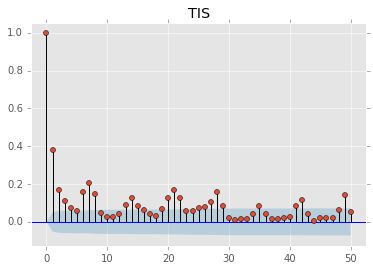

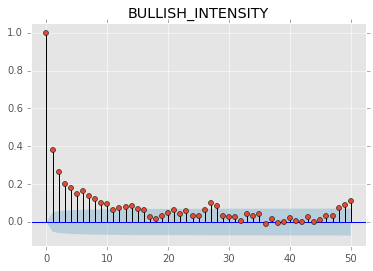

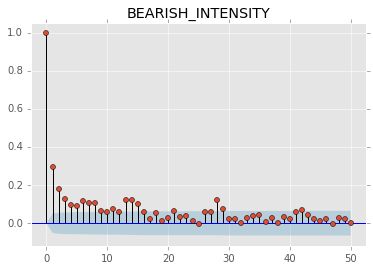

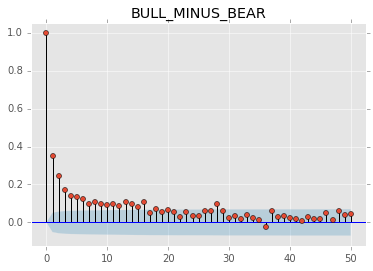

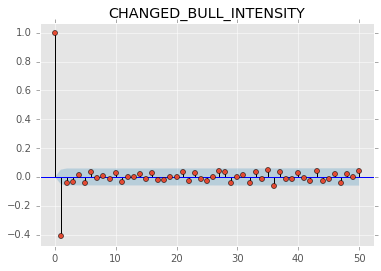

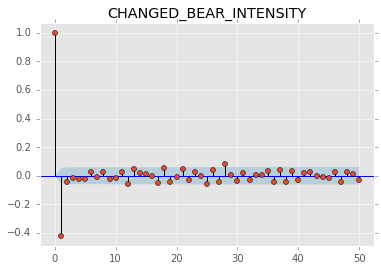

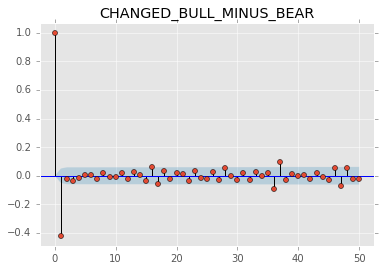

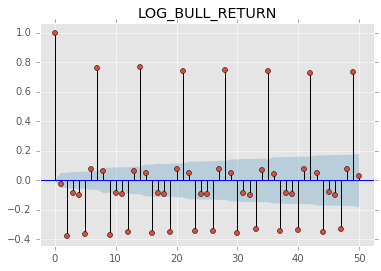

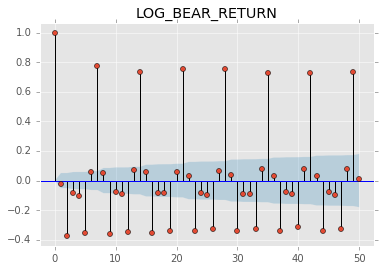

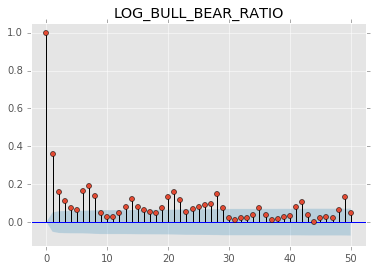

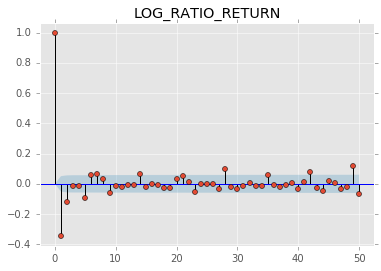

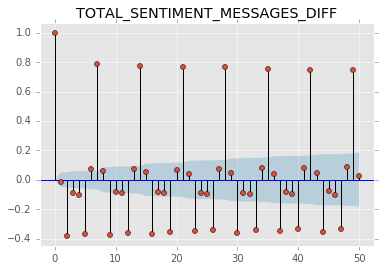

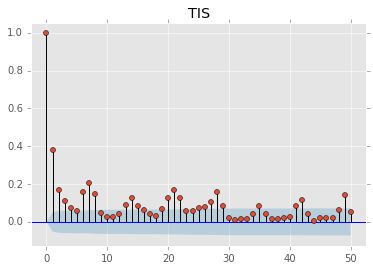

In [27]:
check_acf(spy)

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


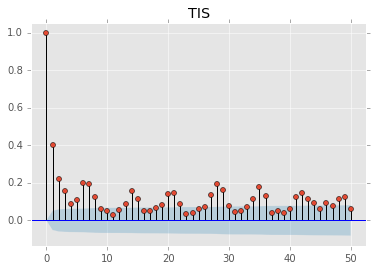

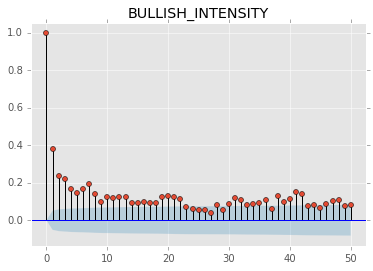

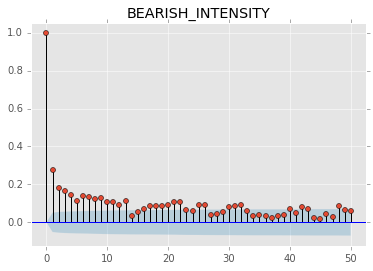

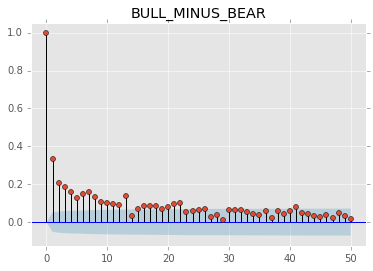

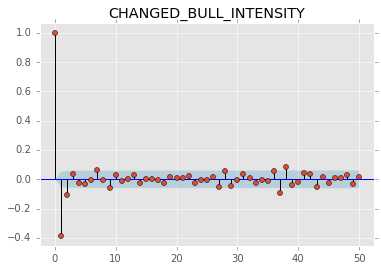

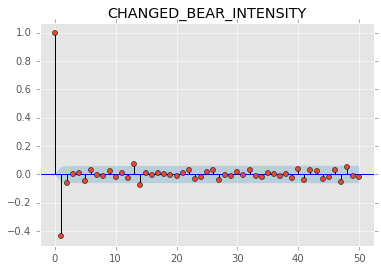

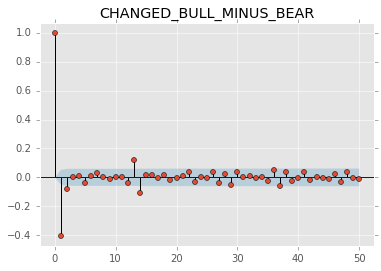

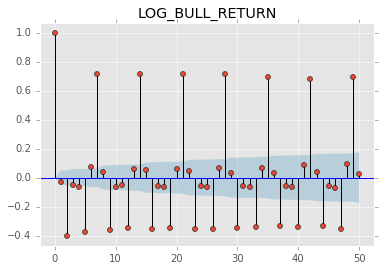

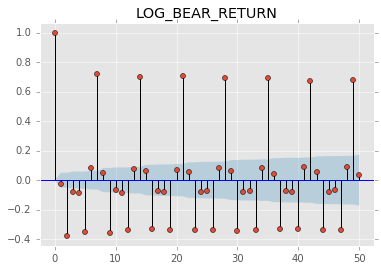

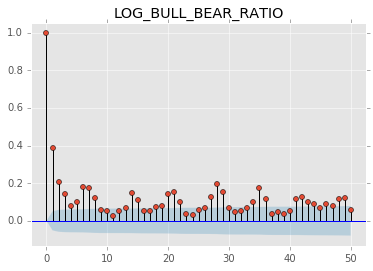

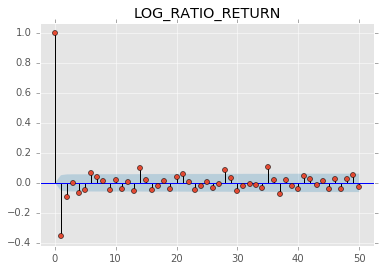

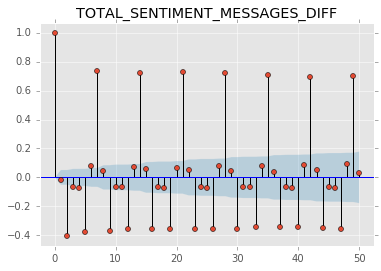

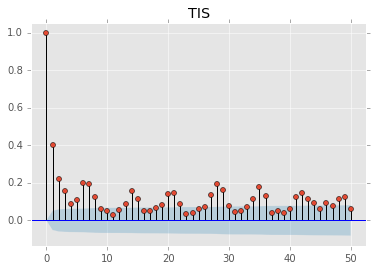

In [19]:
check_acf(app)
# LOG_BULL_RETURN, LOG_BEAR_RETURN, LOG_BULL_BEAR_RATIO, LOG_RATIO_RETURN, TOTAL_SENTIMENT_MENSSAGES_DIFF, TIS 7

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


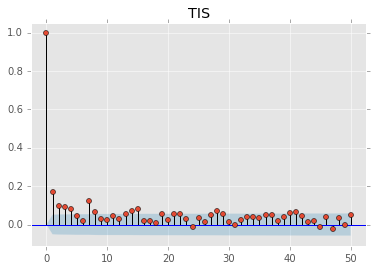

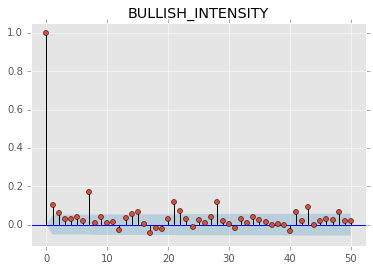

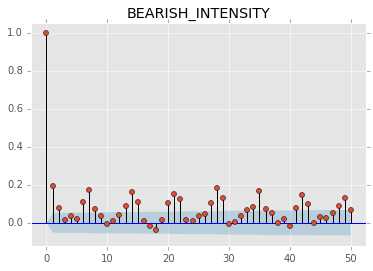

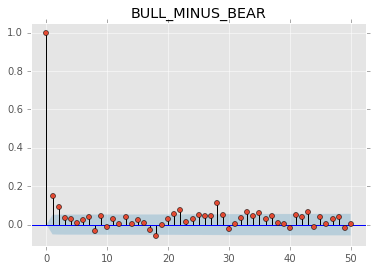

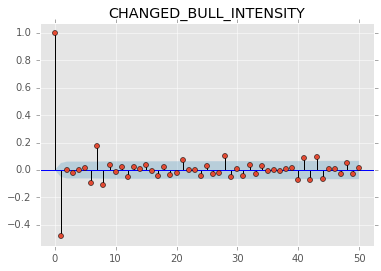

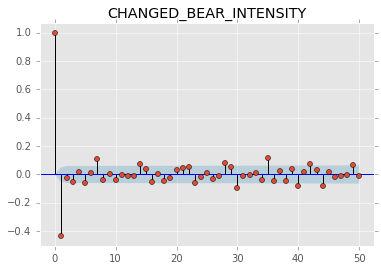

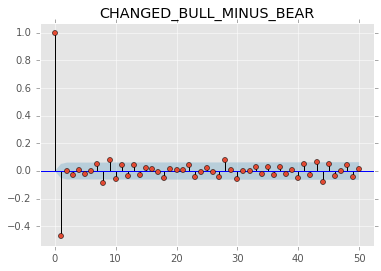

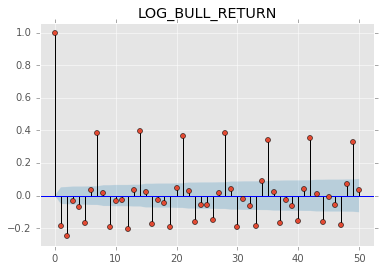

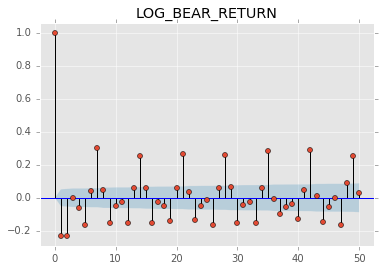

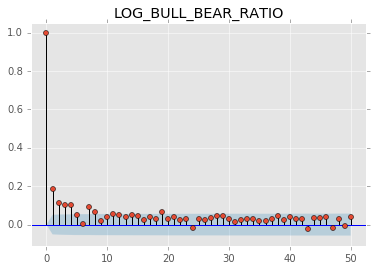

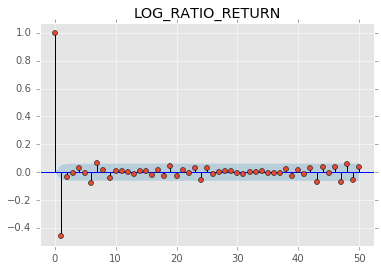

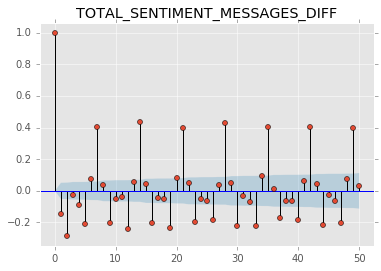

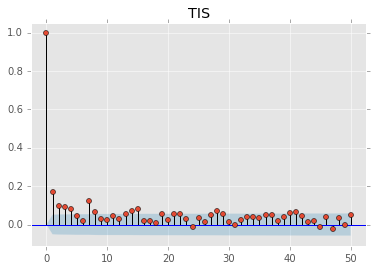

In [20]:
check_acf(intel)
# BULLISH_INTENSITY,20
# BEARISH_INTENSITY,CHANGED_BEAR_INTENSITY, LOG_BULL_RETURN, LOG_BEAR_RETURN,TOTAL_SENTIMENT_MENSSAGES_DIFF, TIS

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


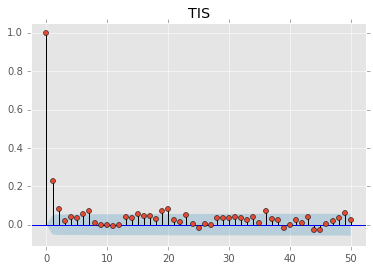

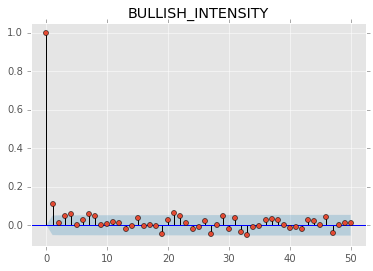

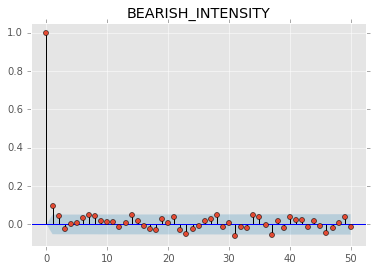

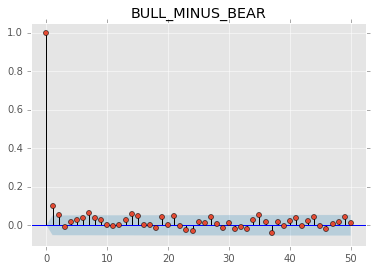

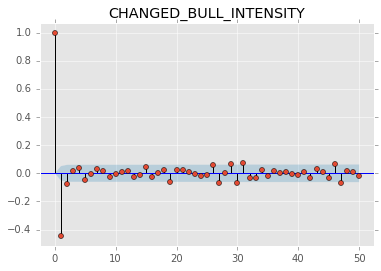

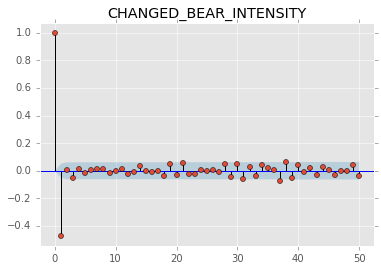

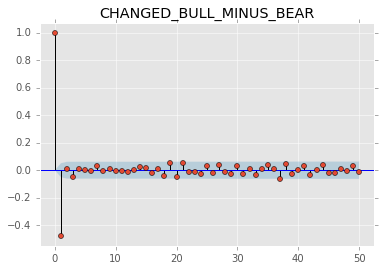

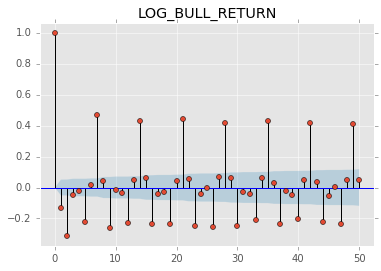

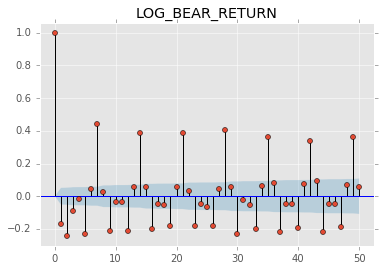

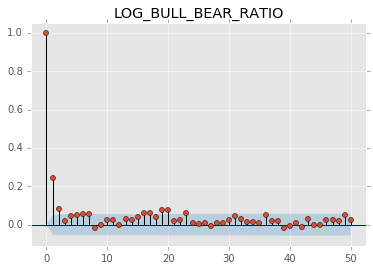

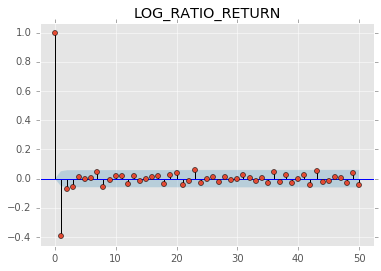

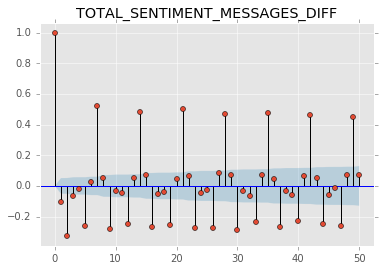

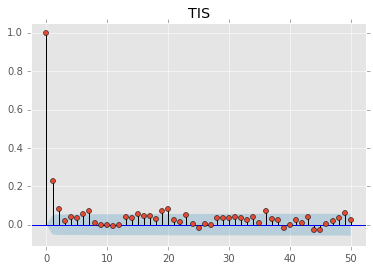

In [21]:
check_acf(msft)
# BEARISH_INTENSITY,BULL_MINUS_BEAR,LOG_BULL_RETURN, LOG_BEAR_RETURN,TOTAL_SENTIMENT_MENSSAGES_DIFF

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


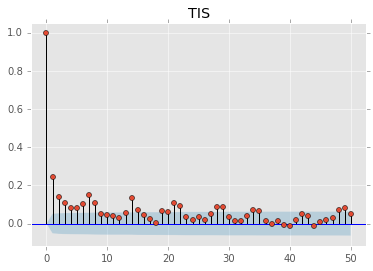

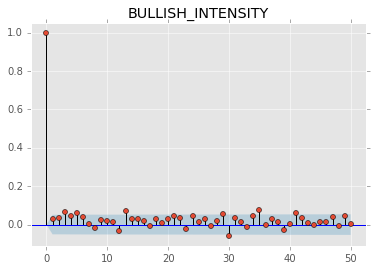

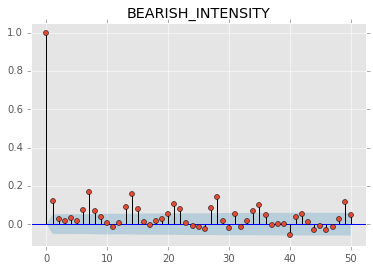

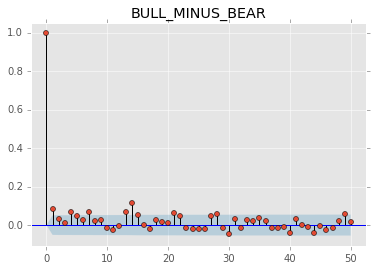

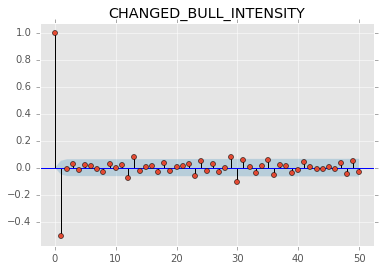

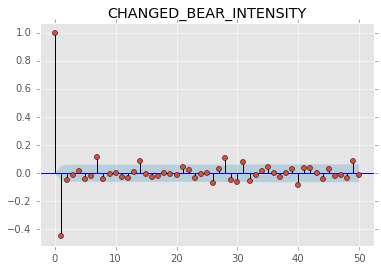

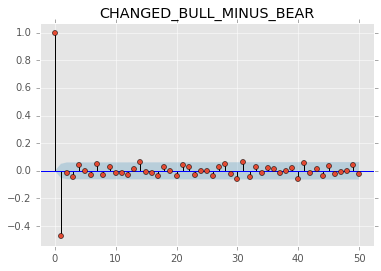

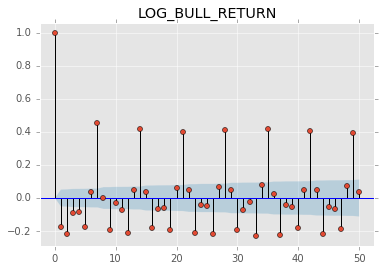

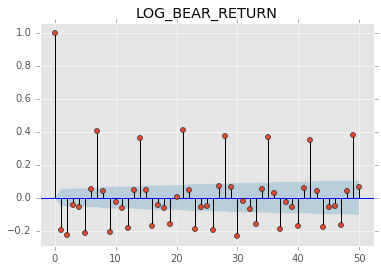

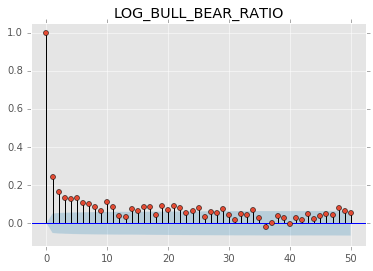

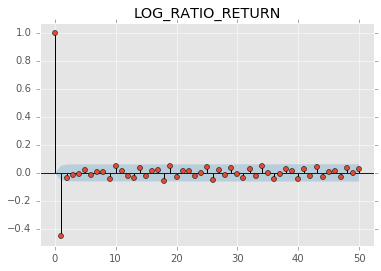

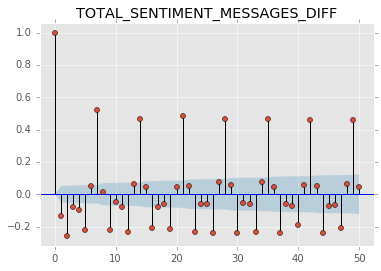

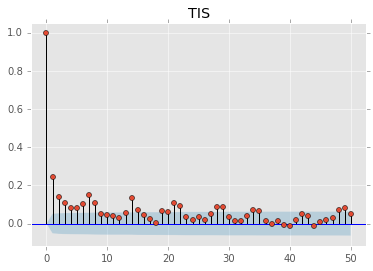

In [22]:
check_acf(jpm)
# BEARISH_INTENSITY,BULL_MINUS_BEAR,CHANGED_BEAR_INTENSITY,LOG_BULL_RETURN, LOG_BEAR_RETURN,TOTAL_SENTIMENT_MENSSAGES_DIFF, TIS

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


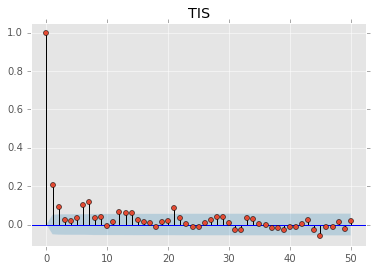

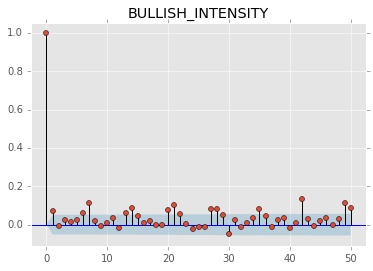

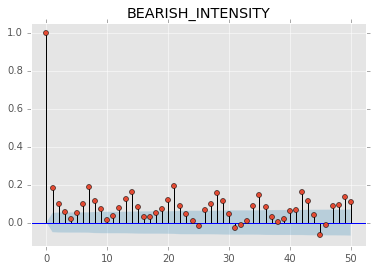

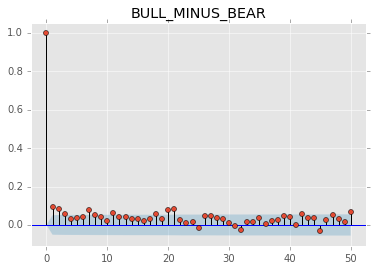

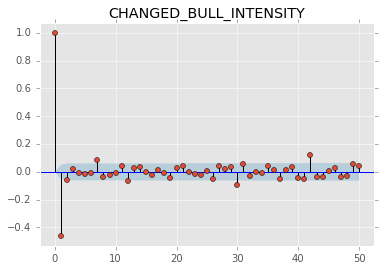

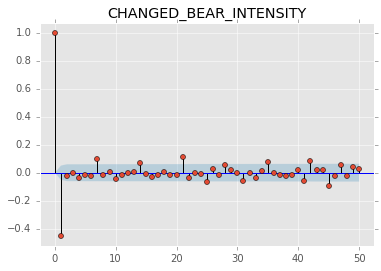

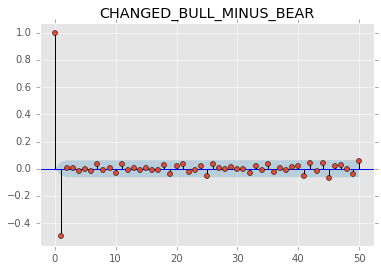

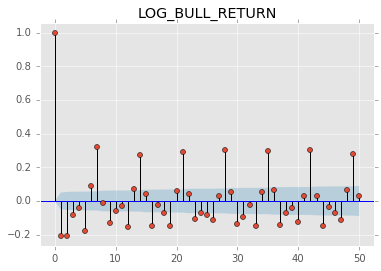

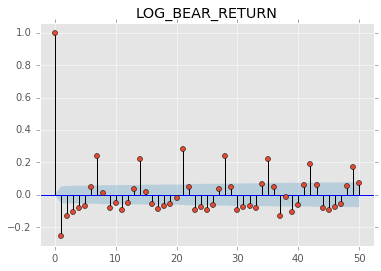

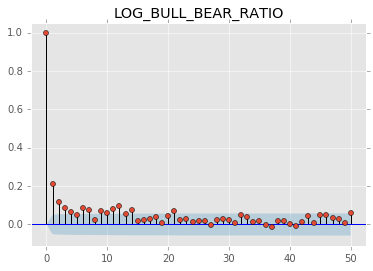

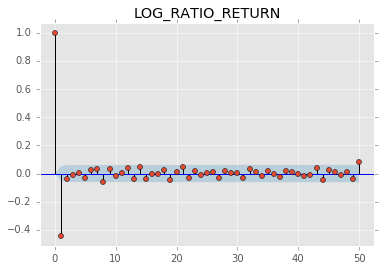

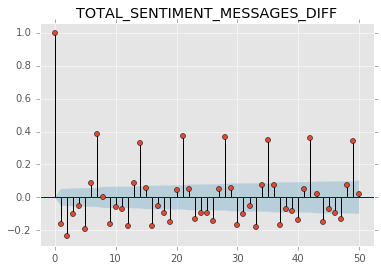

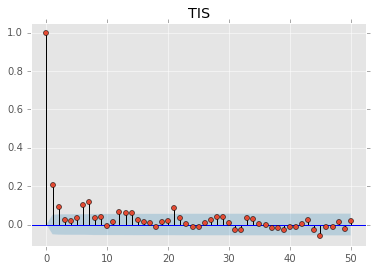

In [23]:
check_acf(csco)
# BULLISH_INTENSITY,BEARISH_INTENSITY,CHANGED_BEAR_INTENSITY,LOG_BULL_RETURN, LOG_BEAR_RETURN,TOTAL_SENTIMENT_MENSSAGES_DIFF,TIS

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


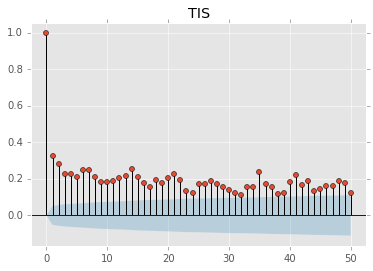

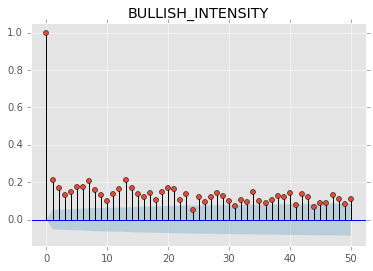

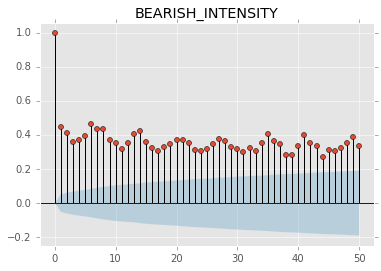

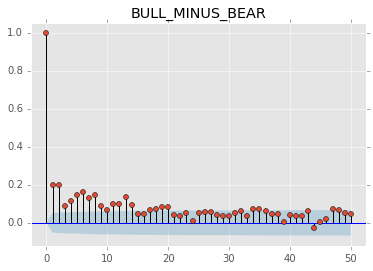

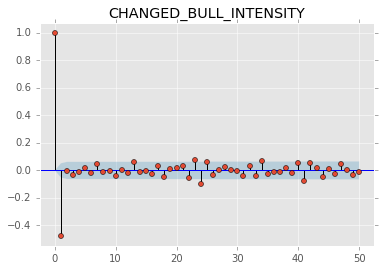

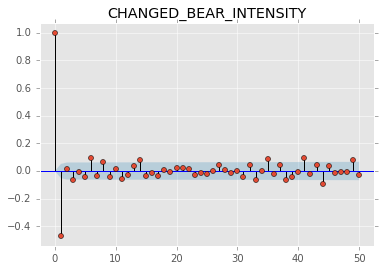

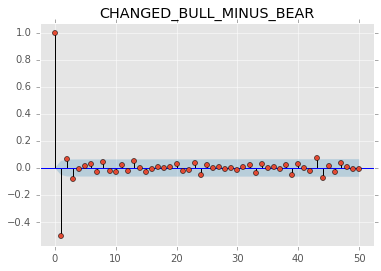

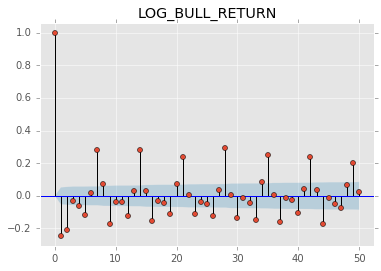

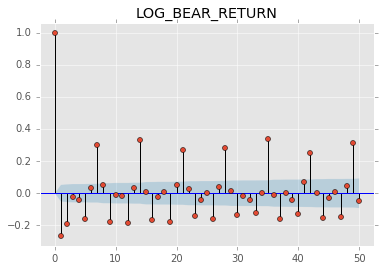

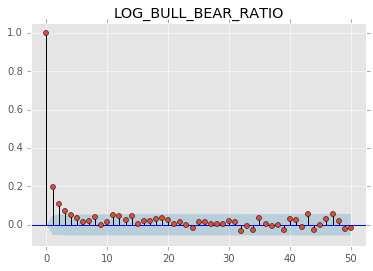

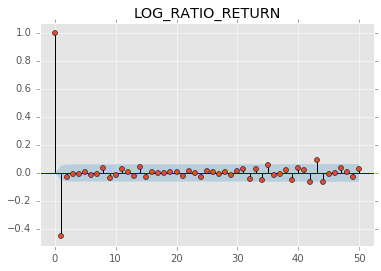

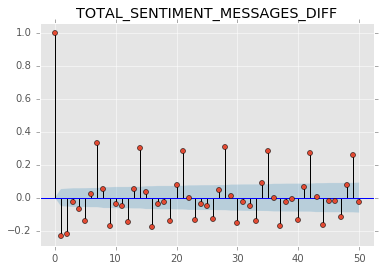

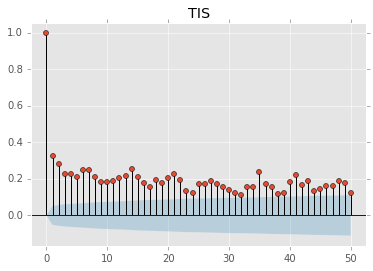

In [124]:
check_acf(ibm)
check_acf(qqq)
check_acf(iwm)

# rolling windows

In [151]:
spy_r = apply_rolling_window(spy,7)
ndx_r = apply_rolling_window(ndx,7)
app_r = apply_rolling_window(app,7)
intel_r = apply_rolling_window(intel, 7)
msft_r = apply_rolling_window(msft, 7)
jpm_r = apply_rolling_window(jpm, 7)
csco_r = apply_rolling_window(csco, 7)
ibm_r = apply_rolling_window(ibm, 7)
qqq_r = apply_rolling_window(qqq, 7)
iwm_r = apply_rolling_window(iwm, 7)

twtr_r = apply_rolling_window(twtr, 7)
nq_r = apply_rolling_window(nq, 7)

# Merged finance and sentiment dataset

In [7]:
spy_rm = merge_sentiment_finance(spy_r, spy_f, True, False, True)
spy_rm.info()
correlation_analysis(spy_rm)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006 entries, 0 to 1005
Data columns (total 35 columns):
SOURCE                           1006 non-null object
SYMBOL                           1006 non-null object
TIMESTAMP_UTC                    1006 non-null object
EXCHANGE                         1006 non-null object
SECTOR                           1006 non-null object
INDUSTRY                         1006 non-null object
TITLE                            1006 non-null object
DATE                             1006 non-null datetime64[ns]
BULLISH_INTENSITY                1006 non-null float64
BEARISH_INTENSITY                1006 non-null float64
BULL_MINUS_BEAR                  1006 non-null float64
BULL_SCORED_MESSAGES             1006 non-null float64
BEAR_SCORED_MESSAGES             1006 non-null float64
BULL_BEAR_MSG_RATIO              1006 non-null float64
TOTAL_SCANNED_MESSAGES           1006 non-null float64
CHANGED_BULL_INTENSITY           1006 non-null float64
CHANGED_BEAR_

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.0323462,0.00736564,-0.279168
BEARISH_INTENSITY,-0.0423158,0.0197278,0.168294
BULL_MINUS_BEAR,0.0498473,-0.00915324,-0.292435
CHANGED_BULL_INTENSITY,0.338586,-0.138638,-0.0951657
CHANGED_BEAR_INTENSITY,-0.180492,0.0360417,-0.0279176
CHANGED_BULL_MINUS_BEAR,0.344033,-0.115095,-0.0424983
BULL_SCORED_MESSAGES,0.0307478,-0.0371382,0.481684
BEAR_SCORED_MESSAGES,-0.0289639,-0.0125471,0.574323
LOG_BULL_RETURN,-0.0326908,0.182234,0.191751
LOG_BEAR_RETURN,-0.278533,0.275037,0.228022


In [8]:
ndx_rm = merge_sentiment_finance(ndx_r, ndx_f, True, False, True)
# app_rm.info()
correlation_analysis(ndx_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.0113772,NaN,0.0888152
BEARISH_INTENSITY,0.0190506,NaN,0.0926423
BULL_MINUS_BEAR,-0.00737234,NaN,-0.0128033
CHANGED_BULL_INTENSITY,-0.00653939,NaN,0.00930181
CHANGED_BEAR_INTENSITY,0.0100827,NaN,-0.00140999
CHANGED_BULL_MINUS_BEAR,-0.0147735,NaN,0.00835785
BULL_SCORED_MESSAGES,-0.00471379,NaN,0.270572
BEAR_SCORED_MESSAGES,-0.000546001,NaN,0.385384
LOG_BULL_RETURN,-0.0124815,NaN,0.0314695
LOG_BEAR_RETURN,0.00521234,NaN,0.0188146


In [9]:
app_rm = merge_sentiment_finance(app_r, app_f, True, False, True)
# app_rm.info()
correlation_analysis(app_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.129429,0.0127395,-0.371936
BEARISH_INTENSITY,-0.0604937,-0.0166884,0.016319
BULL_MINUS_BEAR,0.122611,0.0201469,-0.232561
CHANGED_BULL_INTENSITY,0.280338,0.0255966,-0.0532372
CHANGED_BEAR_INTENSITY,-0.207986,0.122152,0.0394277
CHANGED_BULL_MINUS_BEAR,0.319986,-0.0750985,-0.0624494
BULL_SCORED_MESSAGES,-0.00473817,-0.0838427,0.163955
BEAR_SCORED_MESSAGES,-0.0848072,-0.0667612,0.308152
LOG_BULL_RETURN,0.0465104,0.275691,0.166526
LOG_BEAR_RETURN,-0.126521,0.256549,0.164225


In [10]:
intel_rm = merge_sentiment_finance(intel_r, intel_f, True, False, True)
# intel_rm.info()
correlation_analysis(intel_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,-0.00347877,-0.00864013,0.148077
BEARISH_INTENSITY,-0.0357628,-0.080728,0.151547
BULL_MINUS_BEAR,0.0301243,0.0675979,-0.0599559
CHANGED_BULL_INTENSITY,0.0745092,-0.0534902,-0.0115141
CHANGED_BEAR_INTENSITY,-0.0216918,0.0221837,0.0303153
CHANGED_BULL_MINUS_BEAR,0.0499068,-0.0414503,-0.0306267
BULL_SCORED_MESSAGES,0.0345542,-0.0404837,0.288892
BEAR_SCORED_MESSAGES,-0.0559089,-0.0385575,0.298093
LOG_BULL_RETURN,0.142661,0.169207,0.217465
LOG_BEAR_RETURN,-0.0705619,0.192197,0.236881


In [11]:
msft_rm = merge_sentiment_finance(msft_r, msft_f, True, False, True)
# msft_rm.info()
correlation_analysis(msft_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.039073,-0.00924031,0.0198259
BEARISH_INTENSITY,-0.0269382,-0.0212925,0.0749997
BULL_MINUS_BEAR,0.0427062,0.0141098,-0.0561883
CHANGED_BULL_INTENSITY,0.0856072,-0.00457652,-0.0211203
CHANGED_BEAR_INTENSITY,-0.0427014,0.0422666,-0.0196316
CHANGED_BULL_MINUS_BEAR,0.0810507,-0.0399179,0.00670673
BULL_SCORED_MESSAGES,0.0243379,-0.000813063,0.292001
BEAR_SCORED_MESSAGES,-0.0873905,-0.0254564,0.212706
LOG_BULL_RETURN,0.149875,0.235248,0.191023
LOG_BEAR_RETURN,-0.0601037,0.163307,0.164505


In [12]:
jpm_rm = merge_sentiment_finance(jpm_r, jpm_f, True, False, True)
# jpm_rm.info()
correlation_analysis(jpm_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.0410533,-0.0217614,0.0376052
BEARISH_INTENSITY,-0.0721609,-0.0181322,0.0895831
BULL_MINUS_BEAR,0.0870463,0.00433438,-0.0596289
CHANGED_BULL_INTENSITY,0.140719,-0.0265151,-0.0210313
CHANGED_BEAR_INTENSITY,-0.0794773,-0.00653009,0.000463194
CHANGED_BULL_MINUS_BEAR,0.134076,-0.00737831,-0.00953995
BULL_SCORED_MESSAGES,-0.0597808,-0.0395066,0.172577
BEAR_SCORED_MESSAGES,-0.153523,-0.0302399,0.193029
LOG_BULL_RETURN,0.109297,0.186097,0.139594
LOG_BEAR_RETURN,-0.138783,0.159144,0.191694


In [13]:
csco_rm = merge_sentiment_finance(csco_r, csco_f, True, False, True)
# csco_rm.info()
correlation_analysis(csco_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,-0.00193921,-0.015854,0.0878243
BEARISH_INTENSITY,-0.0500607,-0.0239324,0.209058
BULL_MINUS_BEAR,0.0461619,0.0145278,-0.152849
CHANGED_BULL_INTENSITY,0.0827058,-0.04178,-0.0123977
CHANGED_BEAR_INTENSITY,-0.0173788,0.00650922,0.0156328
CHANGED_BULL_MINUS_BEAR,0.0546423,-0.025535,-0.0201158
BULL_SCORED_MESSAGES,0.0228268,-0.0580904,0.181703
BEAR_SCORED_MESSAGES,-0.123471,-0.0387931,0.151866
LOG_BULL_RETURN,0.0930278,0.163922,0.0993784
LOG_BEAR_RETURN,-0.0869888,0.204126,0.0997777


In [14]:
ibm_rm = merge_sentiment_finance(ibm_r, ibm_f, True, False, True)
# ibm_rm.info()
correlation_analysis(ibm_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.00789377,-0.00913678,-0.0662556
BEARISH_INTENSITY,0.00535262,-0.0412046,0.0406604
BULL_MINUS_BEAR,-0.000347315,0.0312763,-0.0728431
CHANGED_BULL_INTENSITY,0.0573668,-0.00917271,-0.0140121
CHANGED_BEAR_INTENSITY,-0.071607,0.02062,0.0224377
CHANGED_BULL_MINUS_BEAR,0.097179,-0.0238554,-0.0330689
BULL_SCORED_MESSAGES,-0.0705064,-0.0458891,0.130706
BEAR_SCORED_MESSAGES,-0.151313,-0.0294265,0.119772
LOG_BULL_RETURN,-0.0229679,0.1668,0.221075
LOG_BEAR_RETURN,-0.231532,0.168501,0.224544


In [137]:
qqq_rm = merge_sentiment_finance(qqq_r, qqq_f, True, False, True)
# ibm_rm.info()
correlation_analysis(qqq_rm)
iwm_rm = merge_sentiment_finance(iwm_r, iwm_f, True, False, True)
# ibm_rm.info()
correlation_analysis(iwm_rm)

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,0.00521205,-0.0113865,-0.128484
BEARISH_INTENSITY,-0.0332449,-0.00285336,0.212914
BULL_MINUS_BEAR,0.0288076,-0.00455944,-0.240996
CHANGED_BULL_INTENSITY,0.231438,-0.109968,-0.067277
CHANGED_BEAR_INTENSITY,-0.0968234,0.0266227,0.0465124
CHANGED_BULL_MINUS_BEAR,0.220191,-0.0906816,-0.0703947
BULL_SCORED_MESSAGES,0.0222429,-0.0311457,0.368338
BEAR_SCORED_MESSAGES,-0.0120091,-0.0211892,0.386853
LOG_BULL_RETURN,-0.00652588,0.200515,0.143299
LOG_BEAR_RETURN,-0.268146,0.223936,0.232042


In [153]:
twtr_rm = merge_sentiment_finance(twtr_r, twtr_f, True, False, True)
twtr_rm.info()
correlation_analysis(twtr_rm)
nq_rm = merge_sentiment_finance(nq_r, nq_f, True, False, True)
nq_rm.info()
correlation_analysis(nq_rm)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 35 columns):
SOURCE                           541 non-null object
SYMBOL                           541 non-null object
TIMESTAMP_UTC                    541 non-null object
EXCHANGE                         541 non-null object
SECTOR                           541 non-null object
INDUSTRY                         541 non-null object
TITLE                            541 non-null object
DATE                             541 non-null datetime64[ns]
BULLISH_INTENSITY                541 non-null float64
BEARISH_INTENSITY                541 non-null float64
BULL_MINUS_BEAR                  541 non-null float64
BULL_SCORED_MESSAGES             541 non-null float64
BEAR_SCORED_MESSAGES             541 non-null float64
BULL_BEAR_MSG_RATIO              541 non-null float64
TOTAL_SCANNED_MESSAGES           541 non-null float64
CHANGED_BULL_INTENSITY           541 non-null float64
CHANGED_BEAR_INTENSITY         

Correlation Matrix,LOG_RETURN,LOG_VOLUME_DIFF,VOLATILITY
BULLISH_INTENSITY,-0.0106866,-0.0137129,0.189007
BEARISH_INTENSITY,-0.0173269,-0.0147211,0.0562566
BULL_MINUS_BEAR,0.00976793,0.00447415,0.0960043
CHANGED_BULL_INTENSITY,0.0540002,0.0241316,-0.0332838
CHANGED_BEAR_INTENSITY,-0.0575599,0.0269697,0.0377721
CHANGED_BULL_MINUS_BEAR,0.0862555,-0.00595142,-0.0558457
BULL_SCORED_MESSAGES,-0.0154144,-0.0391064,0.368411
BEAR_SCORED_MESSAGES,-0.0438122,-0.0387805,0.385749
LOG_BULL_RETURN,0.114147,0.219656,0.227719
LOG_BEAR_RETURN,-0.0292212,0.211263,0.282839


# Information surplus

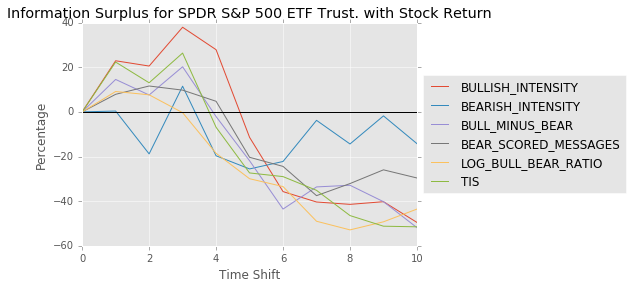

SHIFT,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,CHANGED_BULL_INTENSITY,CHANGED_BEAR_INTENSITY,CHANGED_BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,LOG_BULL_RETURN,LOG_BEAR_RETURN,LOG_BULL_BEAR_RATIO,LOG_RATIO_RETURN,TOTAL_SENTIMENT_MESSAGES_DIFF,TIS
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,22.900487,0.376156,14.533655,-40.035452,-36.691771,-53.945867,-1.086034,7.868422,-41.327001,-51.198303,9.129787,-50.422625,-37.816938,22.319049
2,20.535723,-18.822932,7.557758,-62.240788,-24.874505,-57.113766,5.472302,11.597592,-22.945613,-59.781953,7.646001,-61.928242,-54.238883,13.038593
3,37.916157,11.507733,20.212968,-62.403069,-36.709277,-60.583746,12.493057,9.742992,-13.544649,-60.077894,-0.354703,-52.905921,-39.844508,26.346176
4,27.859337,-19.670945,-2.105720,-63.325614,-17.520010,-61.995564,3.100501,4.746247,-17.300031,-62.487114,-18.558168,-68.871926,-38.633846,-6.893533
5,-11.398161,-25.555341,-21.886551,-18.663378,-24.315633,-30.789314,-5.930999,-20.345809,4.646928,-16.371784,-29.944916,-31.450531,-10.565433,-27.356225
6,-35.715290,-22.220483,-43.534059,-50.597393,-41.060878,-67.789993,-20.309363,-24.430082,-27.932774,-64.983550,-33.464228,-57.374856,-47.803232,-29.002478
7,-40.375360,-3.790070,-33.619557,-69.305546,-48.726058,-64.331562,-23.147998,-37.536323,-33.832221,-60.374288,-48.999496,-65.522737,-42.769529,-35.144277
8,-41.431626,-14.379237,-32.876987,-71.568392,-51.501477,-67.596431,-38.376375,-32.117825,-44.998154,-66.670487,-52.868829,-62.872132,-53.123115,-46.452734
9,-40.242544,-1.798805,-40.232794,-69.561582,-50.405409,-72.105385,-17.720257,-25.966417,-39.840570,-64.599109,-49.248944,-66.459242,-51.283069,-51.217056


In [30]:
spy_is = create_df_for_company(spy_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(spy_is,'Information Surplus for SPDR S&P 500 ETF Trust. with Stock Return','Time Shift(day)', 'Percentage')
spy_is

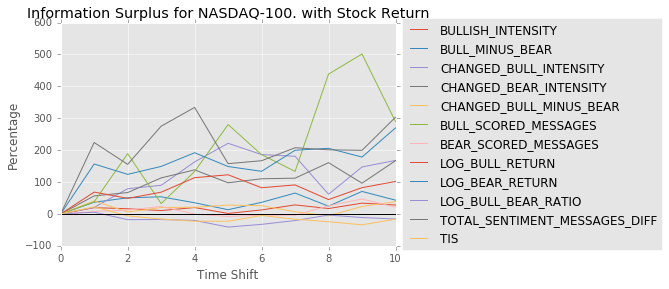

In [18]:
ndx_is = create_df_for_company(ndx_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(ndx_is,'Information Surplus for NASDAQ-100. with Stock Return','Time Shift(day)', 'Percentage')
# ndx_is
# ndx_rm.fillna(0,inplace=True)
# ndx_rm.info()

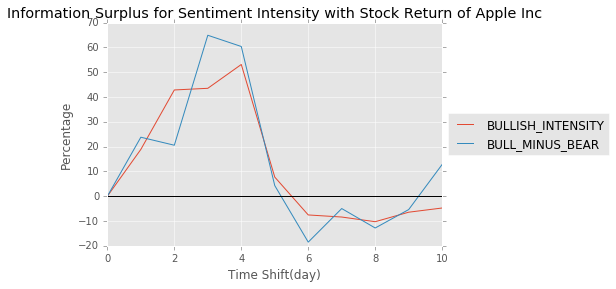

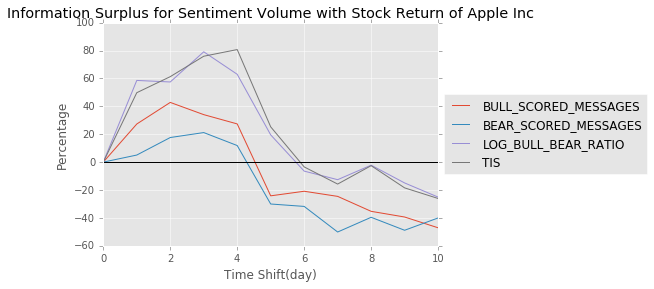

In [53]:
app_is = create_df_for_company(app_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(app_is.ix[:,:6],'Information Surplus for Sentiment Intensity with Stock Return of Apple Inc','Time Shift(day)', 'Percentage')
plot_positive_results(app_is.ix[:,6:],'Information Surplus for Sentiment Volume with Stock Return of Apple Inc','Time Shift(day)', 'Percentage')

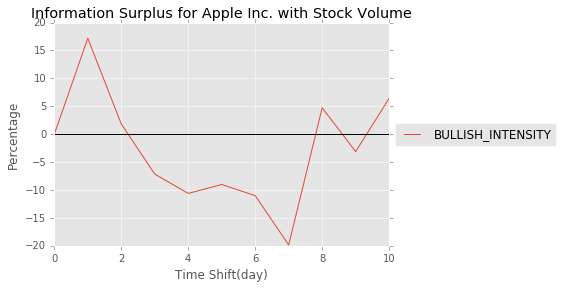

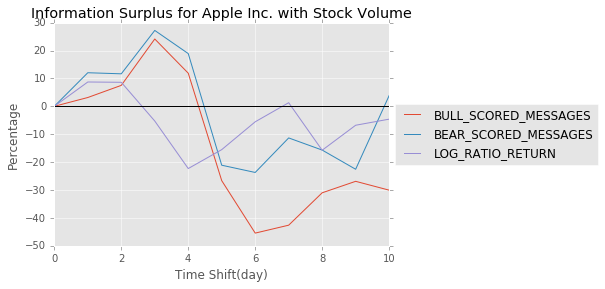

In [54]:
app_is_v = create_df_for_company(app_rm, 10,'LOG_VOLUME_DIFF','INFORMATION_SURPLUS_PCT')
plot_positive_results(app_is_v.ix[:,:6],'Information Surplus for Apple Inc. with Stock Volume','Time Shift(day)', 'Percentage')
plot_positive_results(app_is_v.ix[:,6:],'Information Surplus for Apple Inc. with Stock Volume','Time Shift(day)', 'Percentage')

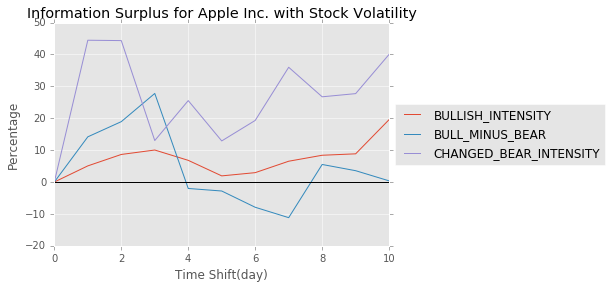

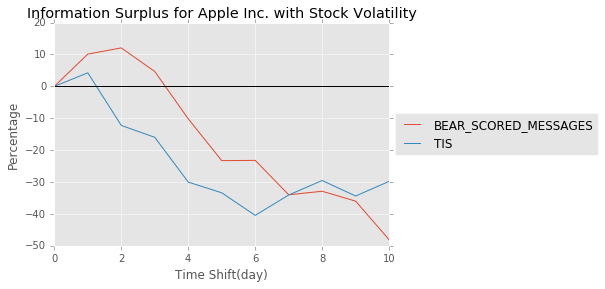

In [55]:
app_is_va = create_df_for_company(app_rm, 10,'VOLATILITY','INFORMATION_SURPLUS_PCT')
plot_positive_results(app_is_va.ix[:,:6],'Information Surplus for Apple Inc. with Stock Volatility','Time Shift(day)', 'Percentage')
plot_positive_results(app_is_va.ix[:,6:],'Information Surplus for Apple Inc. with Stock Volatility','Time Shift(day)', 'Percentage')

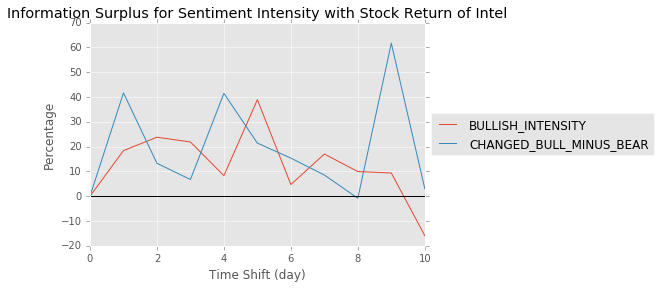

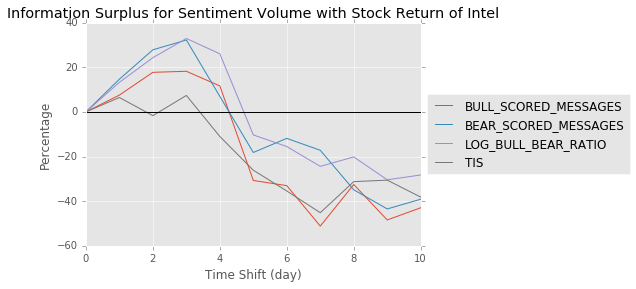

In [69]:
intel_is = create_df_for_company(intel_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(intel_is.ix[:,:6],'Information Surplus for Sentiment Intensity with Stock Return of Intel','Time Shift (day)', 'Percentage')
plot_positive_results(intel_is.ix[:,6:],'Information Surplus for Sentiment Volume with Stock Return of Intel','Time Shift (day)', 'Percentage')

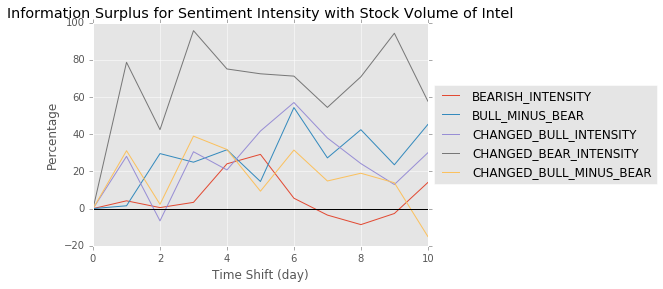

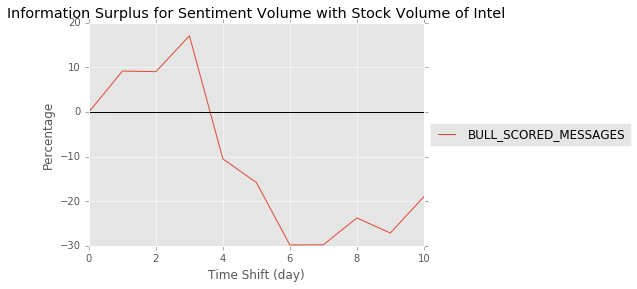

In [70]:
intel_is_v = create_df_for_company(intel_rm, 10,'LOG_VOLUME_DIFF','INFORMATION_SURPLUS_PCT')
plot_positive_results(intel_is_v.ix[:,:6],'Information Surplus for Sentiment Intensity with Stock Volume of Intel','Time Shift (day)', 'Percentage')
plot_positive_results(intel_is_v.ix[:,6:],'Information Surplus for Sentiment Volume with Stock Volume of Intel','Time Shift (day)', 'Percentage')

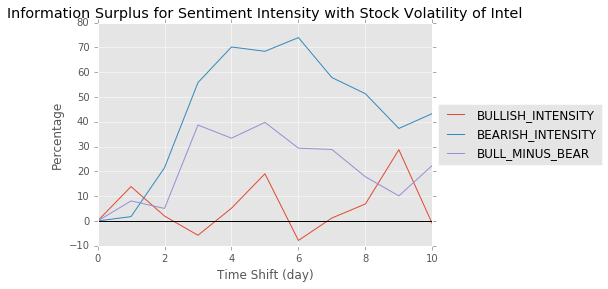

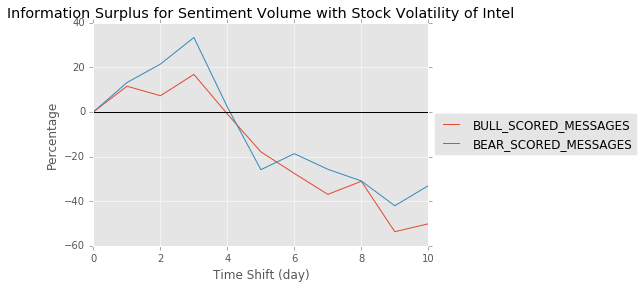

In [71]:
intel_is_va = create_df_for_company(intel_rm, 10,'VOLATILITY','INFORMATION_SURPLUS_PCT')
plot_positive_results(intel_is_va.ix[:,:6],'Information Surplus for Sentiment Intensity with Stock Volatility of Intel','Time Shift (day)', 'Percentage')
plot_positive_results(intel_is_va.ix[:,6:],'Information Surplus for Sentiment Volume with Stock Volatility of Intel','Time Shift (day)', 'Percentage')

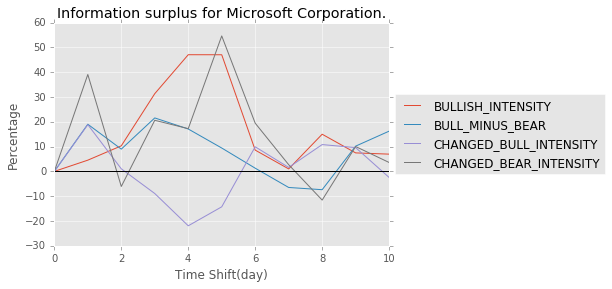

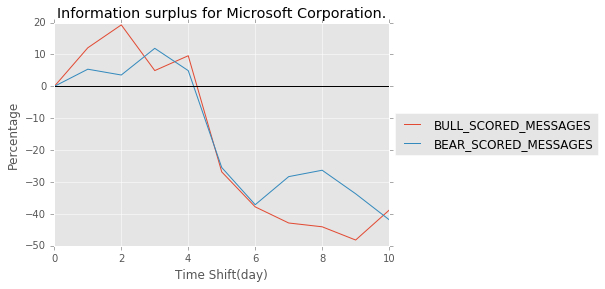

In [60]:
msft_is = create_df_for_company(msft_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(msft_is.ix[:,:6],'Information surplus for Microsoft Corporation.','Time Shift(day)', 'Percentage')
plot_positive_results(msft_is.ix[:,6:],'Information surplus for Microsoft Corporation.','Time Shift(day)', 'Percentage')

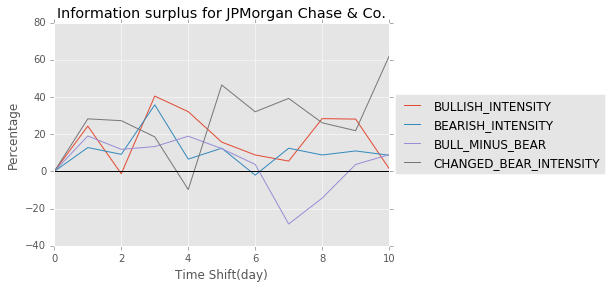

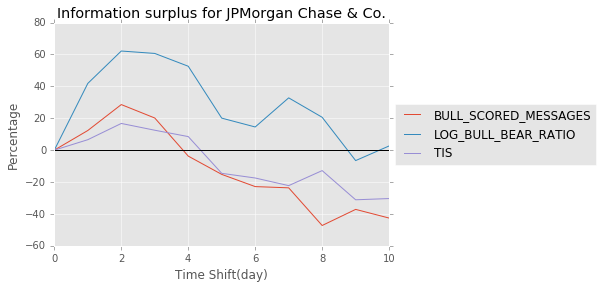

In [61]:
jpm_is = create_df_for_company(jpm_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(jpm_is.ix[:,:6],'Information surplus for JPMorgan Chase & Co.','Time Shift(day)', 'Percentage')
plot_positive_results(jpm_is.ix[:,6:],'Information surplus for JPMorgan Chase & Co.','Time Shift(day)', 'Percentage')

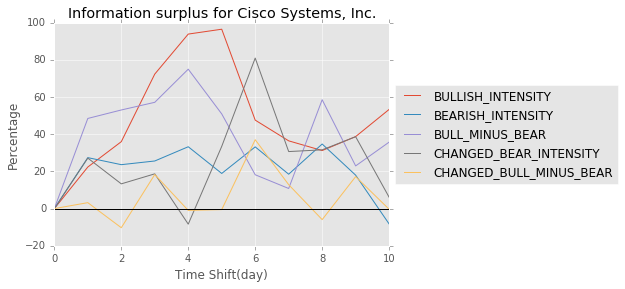

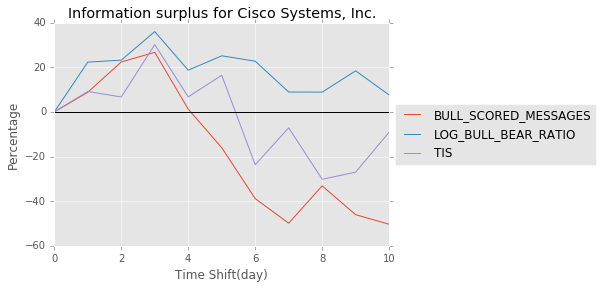

In [62]:
csco_is = create_df_for_company(csco_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(csco_is.ix[:,:6],'Information surplus for Cisco Systems, Inc.','Time Shift(day)', 'Percentage')
plot_positive_results(csco_is.ix[:,6:],'Information surplus for Cisco Systems, Inc.','Time Shift(day)', 'Percentage')

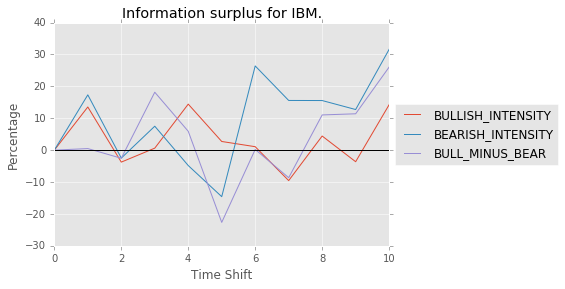

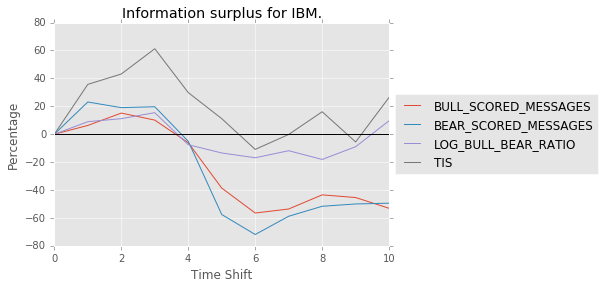

In [52]:
ibm_is = create_df_for_company(ibm_rm, 10,'LOG_RETURN','INFORMATION_SURPLUS_PCT')
plot_positive_results(ibm_is.ix[:,:6],'Information surplus for IBM.','Time Shift(day)', 'Percentage')
plot_positive_results(ibm_is.ix[:,6:],'Information surplus for IBM.','Time Shift(day)', 'Percentage')

# Mutual information

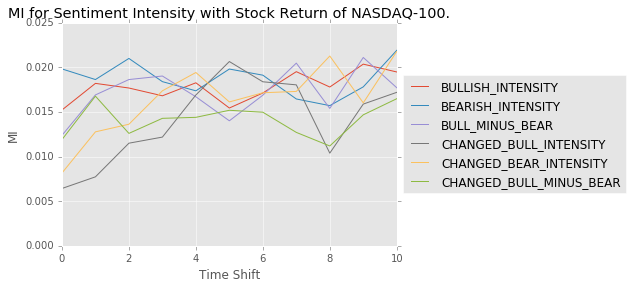

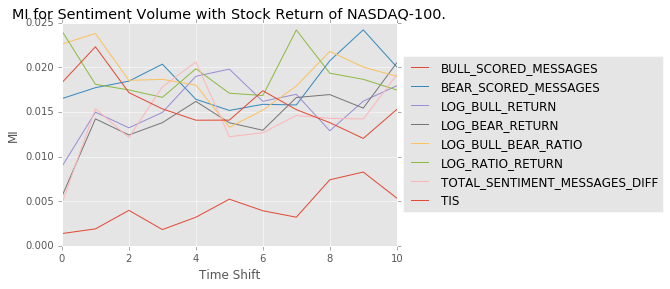

In [24]:
ndx_mi = create_df_for_company(ndx_rm, 10,'LOG_RETURN','MUTUAL INFORMATION')
plot_positive_results(ndx_mi.ix[:,:6],'MI for Sentiment Intensity with Stock Return of NASDAQ-100.','Time Shift', 'MI')
plot_positive_results(ndx_mi.ix[:,6:],'MI for Sentiment Volume with Stock Return of NASDAQ-100.','Time Shift', 'MI')

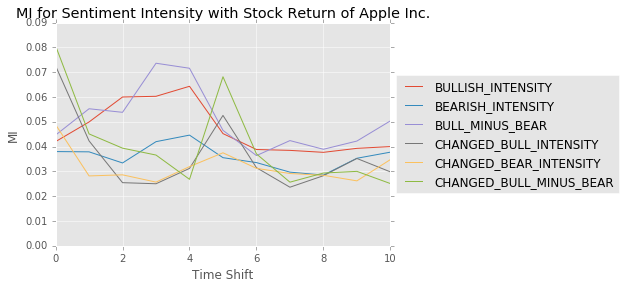

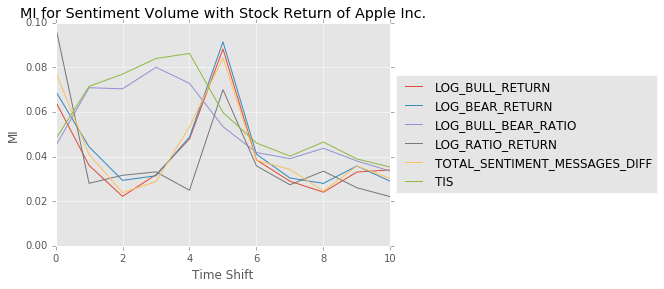

In [31]:
app_mi = create_df_for_company(app_rm, 10,'LOG_RETURN','MUTUAL INFORMATION')
plot_positive_results(app_mi.ix[:,:6],'MI for Sentiment Intensity with Stock Return of Apple Inc.','Time Shift', 'MI')
plot_positive_results(app_mi.ix[:,8:],'MI for Sentiment Volume with Stock Return of Apple Inc.','Time Shift', 'MI')

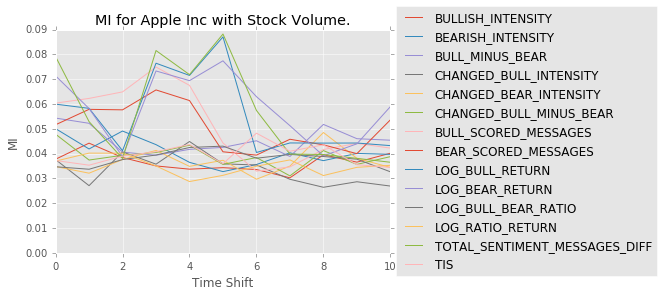

In [147]:
app_mi_v = create_df_for_company(app_rm, 10,'LOG_VOLUME_DIFF','MUTUAL INFORMATION')
plot_positive_results(app_mi_v,'MI for Apple Inc with Stock Volume.','Time Shift', 'MI')

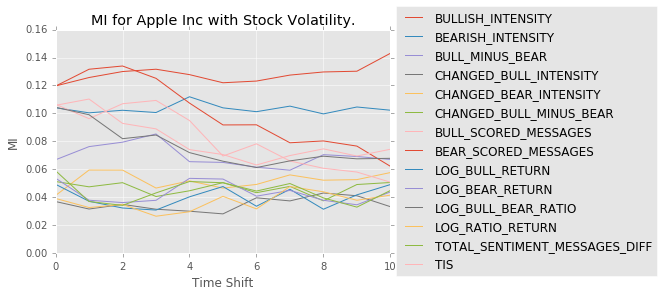

In [153]:
app_mi_va = create_df_for_company(app_rm, 10,'VOLATILITY','MUTUAL INFORMATION')
plot_positive_results(app_mi_va,'MI for Apple Inc with Stock Volatility.','Time Shift', 'MI')

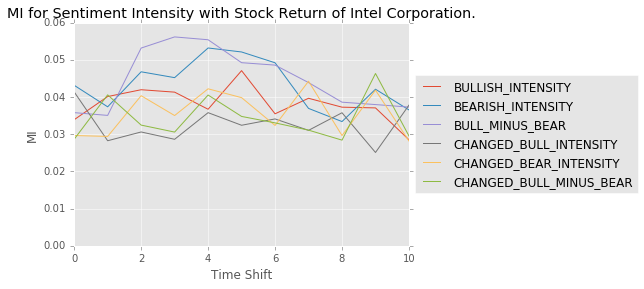

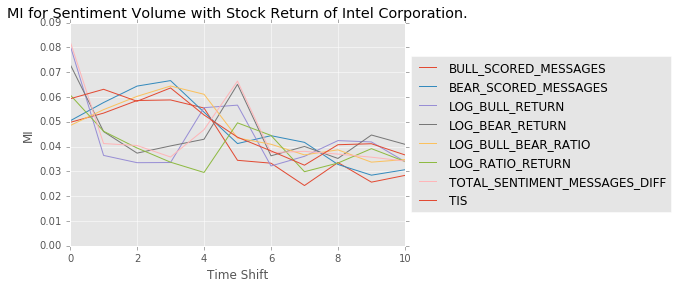

In [46]:
intel_mi = create_df_for_company(intel_rm, 10,'LOG_RETURN','MUTUAL INFORMATION')
plot_positive_results(intel_mi.ix[:,:6],'MI for Sentiment Intensity with Stock Return of Intel Corporation.','Time Shift', 'MI')
plot_positive_results(intel_mi.ix[:,6:],'MI for Sentiment Volume with Stock Return of Intel Corporation.','Time Shift', 'MI')

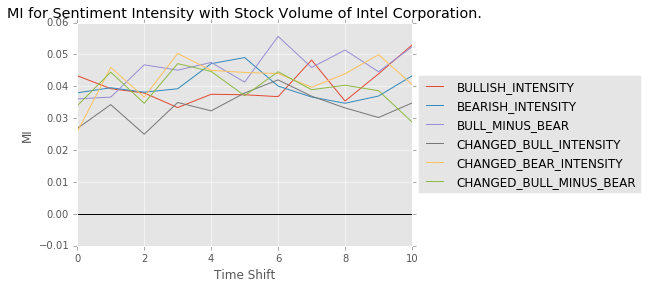

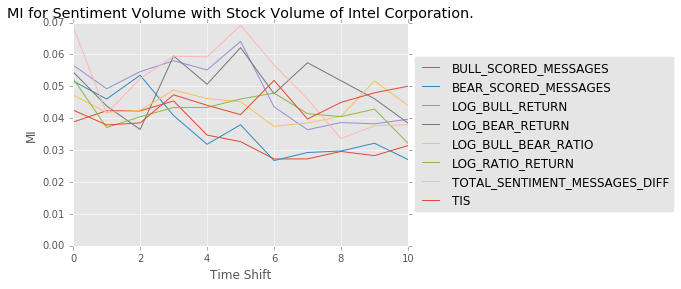

In [34]:
intel_mi_v = create_df_for_company(intel_rm, 10,'LOG_VOLUME_DIFF','MUTUAL INFORMATION')
plot_positive_results(intel_mi_v.ix[:,:6],'MI for Sentiment Intensity with Stock Volume of Intel Corporation.','Time Shift', 'MI')
plot_positive_results(intel_mi_v.ix[:,6:],'MI for Sentiment Volume with Stock Volume of Intel Corporation.','Time Shift', 'MI')

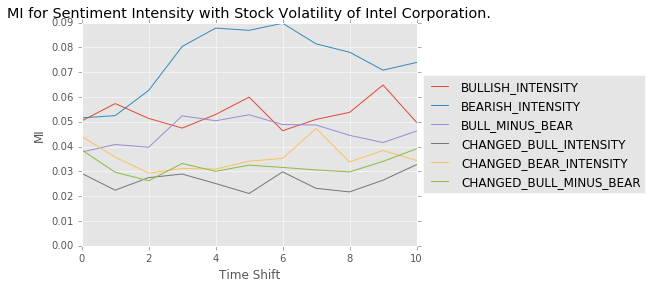

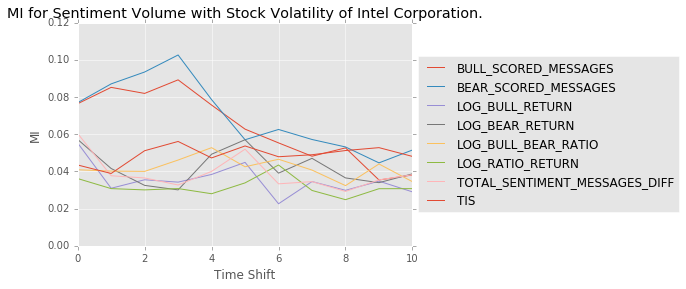

In [33]:
intel_mi_va = create_df_for_company(intel_rm, 10,'VOLATILITY','MUTUAL INFORMATION')
plot_positive_results(intel_mi_va.ix[:,:6],'MI for Sentiment Intensity with Stock Volatility of Intel Corporation.','Time Shift', 'MI')
plot_positive_results(intel_mi_va.ix[:,6:],'MI for Sentiment Volume with Stock Volatility of Intel Corporation.','Time Shift', 'MI')

# Summary Table for mutual information and information surplus with one feature combination of one company

In [74]:
information_surplus(intel_rm, 10,'BULLISH_INTENSITY','LOG_RETURN')

,SHIFT,MUTUAL INFORMATION,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT
0,0,0.033894,0.000000,0.000000
1,1,0.040120,0.006227,18.370944
2,2,0.041955,0.008062,23.784797
3,3,0.041306,0.007413,21.870299
4,4,0.036711,0.002817,8.311502
5,5,0.047085,0.013191,38.919371
6,6,0.035483,0.001589,4.688999
7,7,0.039656,0.005762,17.000990
8,8,0.037265,0.003371,9.946606
9,9,0.037069,0.003176,9.369543


# PCA

In [155]:
def get_pca_df(df):
    # dimensionality reduce for finance features
    pca_finance = PCA(n_components=1).fit_transform(df.ix[1:,-3:])
    pca_finance_df = pd.DataFrame(pca_finance, columns = ['FINANCE_FEATURE'])
    # dimensionality reduce for sentiment features
    sentiment_df = df.ix[1:,8:-9]
    sentiment_df = sentiment_df.drop(sentiment_df.columns[[5, 6, -2,-3]], axis=1)
    sentiment_df.fillna(0,inplace=True)
    pca_sentiment = PCA(n_components=1).fit_transform(sentiment_df)
    pca_sentiment_df = pd.DataFrame(pca_sen, columns = ['SENTIMENT_FEATURE'])
    return pd.concat([pca_finance_df, pca_sentiment_df], axis=1)
    

In [199]:
pca_intel = get_pca_df(intel_rm)
pca_spy = get_pca_df(spy_rm)
pca_app = get_pca_df(app_rm)
pca_msft = get_pca_df(msft_rm)
pca_jpm = get_pca_df(jpm_rm)
pca_csco = get_pca_df(csco_rm)
pca_ibm = get_pca_df(ibm_rm)
pca_qqq = get_pca_df(qqq_rm)
pca_iwm = get_pca_df(iwm_rm)
pca_twtr = get_pca_df(twtr_rm)
pca_nq = get_pca_df(nq_rm)
pca_intel.head(6)

,FINANCE_FEATURE,SENTIMENT_FEATURE
0,0.094009,12.126797
1,0.027796,6.427689
2,-0.325328,6.501389
3,0.185083,8.810349
4,-0.167019,8.954291
5,0.325961,8.133948


In [197]:
# optimal lag: 3; max lag: 4
intel_p = information_surplus(pca_intel, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE')   
intel_p

,SHIFT,MUTUAL INFORMATION,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT
0,0,0.040790,0.000000,0.000000
1,1,0.050288,0.009498,23.285710
2,2,0.059147,0.018357,45.004519
3,3,0.070353,0.029563,72.477067
4,4,0.052533,0.011743,28.790112
5,5,0.032436,-0.008354,-20.479419
6,6,0.029015,-0.011775,-28.867115
7,7,0.034362,-0.006428,-15.758136
8,8,0.033297,-0.007493,-18.369827
9,9,0.028499,-0.012291,-30.131376


In [162]:
# optimal lag: 2; max lag: 4
spy_p = information_surplus(pca_spy, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [163]:
# optimal lag: 3; max lag: 5
app_p = information_surplus(pca_app, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [173]:
# optimal lag: 2; max lag: 4
msft_p = information_surplus(pca_msft, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [168]:
# optimal lag: 3; max lag: 7
jpm_p = information_surplus(pca_jpm, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [169]:
# optimal lag: 0; max lag: 0
csco_p = information_surplus(pca_csco, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [170]:
# optimal lag: 1; max lag: 1
ibm_p = information_surplus(pca_ibm, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [171]:
# optimal lag: 2; max lag: 5
qqq_p = information_surplus(pca_qqq, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [172]:
# optimal lag: 4; max lag: 6
iwm_p = information_surplus(pca_iwm, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

In [159]:
# optimal lag: 0; max lag: 0
# information_surplus(pca_twtr, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

,SHIFT,MUTUAL INFORMATION,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT
0,0,0.046225,0.000000,0.000000
1,1,0.050117,0.003892,8.420278
2,2,0.045815,-0.000410,-0.887455
3,3,0.046221,-0.000004,-0.009010
4,4,0.046372,0.000147,0.317227
5,5,0.049876,0.003651,7.898596
6,6,0.048298,0.002073,4.484369
7,7,0.046682,0.000456,0.987265
8,8,0.051962,0.005737,12.411531
9,9,0.052551,0.006326,13.684503


In [160]:
# optimal lag: 0; max lag: 0
# information_surplus(pca_nq, 10, 'SENTIMENT_FEATURE','FINANCE_FEATURE') 

,SHIFT,MUTUAL INFORMATION,INFORMATION_SURPLUS_DIFF,INFORMATION_SURPLUS_PCT
0,0,0.026660,0.000000,0.000000
1,1,0.019835,-0.006825,-25.598595
2,2,0.022584,-0.004075,-15.286902
3,3,0.021082,-0.005578,-20.922766
4,4,0.022145,-0.004515,-16.933847
5,5,0.022546,-0.004114,-15.431331
6,6,0.021307,-0.005353,-20.078731
7,7,0.020877,-0.005783,-21.691974
8,8,0.021092,-0.005568,-20.886245
9,9,0.021836,-0.004824,-18.095450


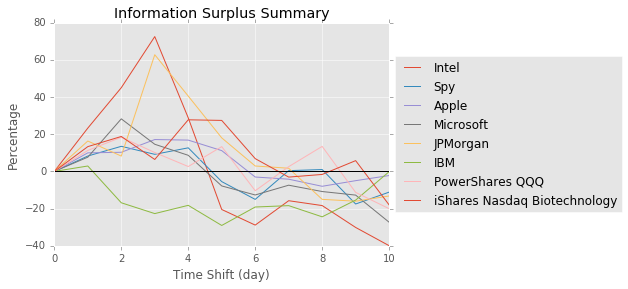

,Intel,Spy,Apple,Microsoft,JPMorgan,IBM,PowerShares QQQ,iShares Nasdaq Biotechnology
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,23.285710,8.265101,9.975477,7.649242,16.331161,2.898129,11.273367,13.319969
2,45.004519,13.479503,10.278984,28.251308,8.237639,-16.870466,18.361496,18.778940
3,72.477067,9.180863,17.126350,14.587523,62.724338,-22.684847,10.150718,6.414491
4,28.790112,12.670629,16.826182,8.650305,40.486630,-18.243784,2.613183,27.744341
5,-20.479419,-5.486555,11.176685,-7.813713,18.029392,-29.061389,13.327330,27.412963
6,-28.867115,-15.047621,-3.020543,-12.673630,2.908133,-19.146910,-10.390216,6.871561
7,-15.758136,0.405125,-4.192458,-7.417249,1.697474,-18.405777,2.546181,-3.055317
8,-18.369827,1.000134,-8.005559,-10.820874,-15.034013,-24.422794,13.442598,-1.637073
9,-30.131376,-17.525730,-4.986270,-12.742382,-16.015700,-15.431092,-11.291982,5.786457


In [215]:
# Apple Inc., Intel Corporation, Microsoft Corporation, JPMorgan Chase & Co., Cisco Systems, Inc., IBM and SPDR S&P 500 ETF Trust
is_df = pd.DataFrame(index = range(11))
is_df['Intel'] = intel_p['INFORMATION_SURPLUS_PCT']
is_df['Spy'] = spy_p['INFORMATION_SURPLUS_PCT']
is_df['Apple'] = app_p['INFORMATION_SURPLUS_PCT']
is_df['Microsoft'] = msft_p['INFORMATION_SURPLUS_PCT']
is_df['JPMorgan'] = jpm_p['INFORMATION_SURPLUS_PCT']
is_df['IBM'] = ibm_p['INFORMATION_SURPLUS_PCT']
is_df['PowerShares QQQ'] = qqq_p['INFORMATION_SURPLUS_PCT']
is_df['iShares Nasdaq Biotechnology'] = iwm_p['INFORMATION_SURPLUS_PCT']
plot_positive_results(is_df,'Information Surplus Summary','Time Shift (day)', 'Percentage')
is_df

In [219]:
lag_df = pd.DataFrame(index = ['Intel','Spy','Apple','Microsoft','JPMorgan','IBM','PowerShares QQQ','iShares Nasdaq Biotechnology'])
lag_df['OPTIMAL_LAG'] = [3,2,3,2,3,1,2,4]
lag_df['MAX_POSITIVE_LAG'] = [4,4,5,4,7,1,5,6]
lag_df['SECTOR'] = ['Technology','Finacial','Technology','Technology','Finacial','Technology','Finacial','Finacial']
lag_df['SECTOR_INDEX'] = [1,2,1,1,2,1,2,2]
lag_df['EXCHANGE'] = ['NASDAQ','NYSEArca','NASDAQ','NASDAQ','NYSE','NYSE','NASDAQ','NYSEArca']
lag_df['EXCHANGE_INDEX'] = [1,3,1,1,2,2,1,3]
lag_df.columns.name = 'Company'
lag_df

Company,OPTIMAL_LAG,MAX_POSITIVE_LAG,SECTOR,SECTOR_INDEX,EXCHANGE,EXCHANGE_INDEX
Intel,3,4,Technology,1,NASDAQ,1
Spy,2,4,Finacial,2,NYSEArca,3
Apple,3,5,Technology,1,NASDAQ,1
Microsoft,2,4,Technology,1,NASDAQ,1
JPMorgan,3,7,Finacial,2,NYSE,2
IBM,1,1,Technology,1,NYSE,2
PowerShares QQQ,2,5,Finacial,2,NASDAQ,1
iShares Nasdaq Biotechnology,4,6,Finacial,2,NYSEArca,3


/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


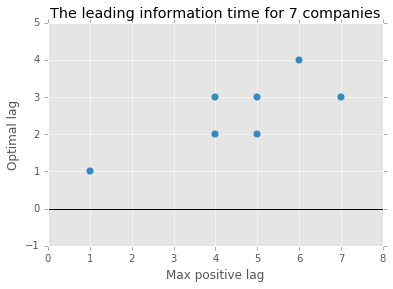

In [220]:
plt.figure()
p = lag_df.plot(kind='scatter', x = 'MAX_POSITIVE_LAG', y = 'OPTIMAL_LAG',title = 'The leading information time for 8 companies', s = 60)
p.set_xlabel('Max positive lag')
p.set_ylabel('Optimal lag')
legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(0, color='k')
plt.show()

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


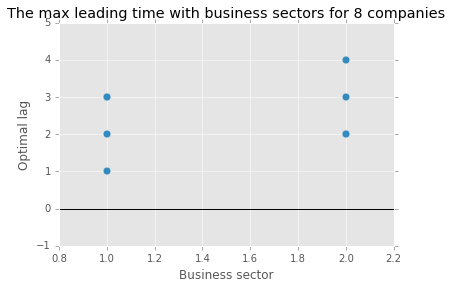

In [221]:
plt.figure()
p = lag_df.plot(kind='scatter', x = 'SECTOR_INDEX', y = 'OPTIMAL_LAG',title = 'The max leading time with business sectors for 8 companies', s = 60)
p.set_xlabel('Business sector')
p.set_ylabel('Optimal lag')
legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(0, color='k')
plt.show()

/Users/jessia/software/Anaconda/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


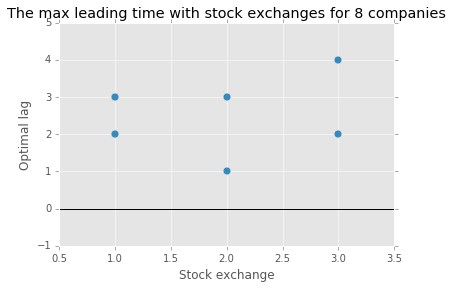

In [222]:
plt.figure()
p = lag_df.plot(kind='scatter', x = 'EXCHANGE_INDEX', y = 'OPTIMAL_LAG',title = 'The max leading time with stock exchanges for 8 companies', s = 60)
p.set_xlabel('Stock exchange')
p.set_ylabel('Optimal lag')
legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(0, color='k')
plt.show()

# K-means

AttributeError: 'PathCollection' object has no attribute 'plt'

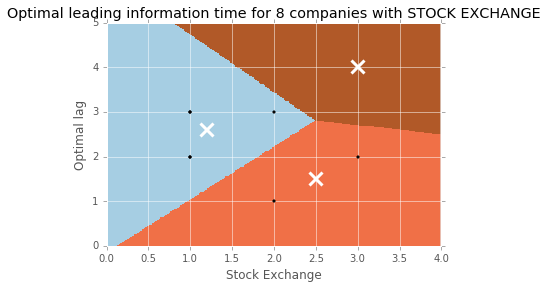

In [257]:
df_t = lag_df.ix[:,['MAX_POSITIVE_LAG','OPTIMAL_LAG']]
df_s = lag_df.ix[:,['SECTOR_INDEX','OPTIMAL_LAG']]
df_e = lag_df.ix[:,['EXCHANGE_INDEX','OPTIMAL_LAG']]
# Convert DataFrame to matrix
mat_t = df_t.as_matrix()
mat_s = df_s.as_matrix()
mat_e = df_e.as_matrix()
km = KMeans()
km.fit(mat_e)
# Get cluster assignment labels
labels = km.labels_
# data = mat_t
# reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(mat_e)
h = .02 
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = mat_e[:, 0].min() - 1, mat_e[:, 0].max() + 1
y_min, y_max = mat_e[:, 1].min() - 1, mat_e[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(mat_e[:, 0], mat_e[:, 1], 'k.', markersize=5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Optimal leading information time for 8 companies with STOCK EXCHANGE')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Stock Exchange')
plt.ylabel('Optimal lag')
p.plt.xlabel('Max positive lag')
p.plt.ylabel('Optimal lag')
plt.xticks(())
plt.yticks(())
plt.show()

AttributeError: 'PathCollection' object has no attribute 'plt'

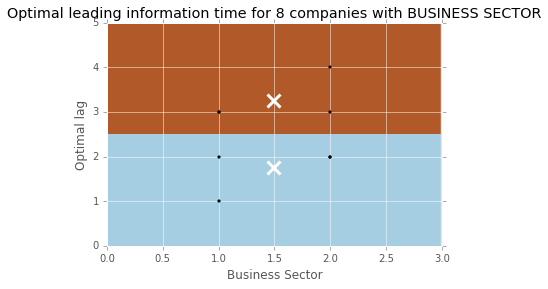

In [259]:
df_t = lag_df.ix[:,['MAX_POSITIVE_LAG','OPTIMAL_LAG']]
df_s = lag_df.ix[:,['SECTOR_INDEX','OPTIMAL_LAG']]
df_e = lag_df.ix[:,['EXCHANGE_INDEX','OPTIMAL_LAG']]
# Convert DataFrame to matrix
mat_t = df_t.as_matrix()
mat_s = df_s.as_matrix()
mat_e = df_e.as_matrix()
km = KMeans()
km.fit(mat_s)
# Get cluster assignment labels
labels = km.labels_
# data = mat_t
# reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(mat_s)
h = .02 
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = mat_s[:, 0].min() - 1, mat_s[:, 0].max() + 1
y_min, y_max = mat_s[:, 1].min() - 1, mat_s[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(mat_s[:, 0], mat_s[:, 1], 'k.', markersize=5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Optimal leading information time for 8 companies with BUSINESS SECTOR')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Business Sector')
plt.ylabel('Optimal lag')
p.plt.xlabel('Max positive lag')
p.plt.ylabel('Optimal lag')
plt.xticks(())
plt.yticks(())
plt.show()

AttributeError: 'PathCollection' object has no attribute 'plt'

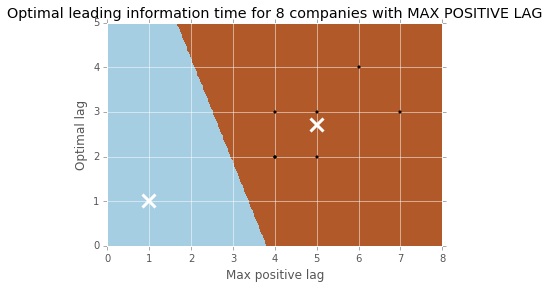

In [260]:
df_t = lag_df.ix[:,['MAX_POSITIVE_LAG','OPTIMAL_LAG']]
df_s = lag_df.ix[:,['SECTOR_INDEX','OPTIMAL_LAG']]
df_e = lag_df.ix[:,['EXCHANGE_INDEX','OPTIMAL_LAG']]
# Convert DataFrame to matrix
mat_t = df_t.as_matrix()
mat_s = df_s.as_matrix()
mat_e = df_e.as_matrix()
km = KMeans()
km.fit(mat_t)
# Get cluster assignment labels
labels = km.labels_
# data = mat_t
# reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(mat_t)
h = .02 
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = mat_t[:, 0].min() - 1, mat_t[:, 0].max() + 1
y_min, y_max = mat_t[:, 1].min() - 1, mat_t[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')
plt.plot(mat_t[:, 0], mat_t[:, 1], 'k.', markersize=5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Optimal leading information time for 8 companies with MAX POSITIVE LAG')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Max positive lag')
plt.ylabel('Optimal lag')
p.plt.xlabel('Max positive lag')
p.plt.ylabel('Optimal lag')
plt.xticks(())
plt.yticks(())
plt.show()

In [105]:
# financial_df = intel_rm.ix[1:,-3:]
pca_fin = PCA(n_components=1).fit_transform(intel_rm.ix[1:,-3:])
pca_fin_df = pd.DataFrame(pca_fin, columns = ['FINANCE FEATURE'])
pca_fin_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1004
Data columns (total 1 columns):
FINANCE FEATURE    1005 non-null float64
dtypes: float64(1)
memory usage: 15.7 KB


In [99]:
sentiment_df = intel_rm.ix[1:,8:-9]
sentiment_df = sentiment_df.drop(sentiment_df.columns[[5, 6, -2,-3]], axis=1)
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 1 to 1005
Data columns (total 14 columns):
BULLISH_INTENSITY                1005 non-null float64
BEARISH_INTENSITY                1005 non-null float64
BULL_MINUS_BEAR                  1005 non-null float64
BULL_SCORED_MESSAGES             1005 non-null float64
BEAR_SCORED_MESSAGES             1005 non-null float64
CHANGED_BULL_INTENSITY           1005 non-null float64
CHANGED_BEAR_INTENSITY           1005 non-null float64
CHANGED_BULL_MINUS_BEAR          1005 non-null float64
LOG_BULL_RETURN                  1005 non-null float64
LOG_BEAR_RETURN                  1005 non-null float64
LOG_BULL_BEAR_RATIO              1005 non-null float64
LOG_RATIO_RETURN                 1005 non-null float64
TIS                              1005 non-null float64
TOTAL_SENTIMENT_MESSAGES_DIFF    1005 non-null float64
dtypes: float64(14)
memory usage: 117.8 KB


In [93]:
pca_sen = PCA(n_components=1).fit_transform(sentiment_df)
pca_sen_df = pd.DataFrame(pca_sen, columns = ['SENTIMENT FEATURE'])
pca_sen_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 1 to 1005
Data columns (total 14 columns):
BULLISH_INTENSITY                1005 non-null float64
BEARISH_INTENSITY                1005 non-null float64
BULL_MINUS_BEAR                  1005 non-null float64
BULL_SCORED_MESSAGES             1005 non-null float64
BEAR_SCORED_MESSAGES             1005 non-null float64
CHANGED_BULL_INTENSITY           1005 non-null float64
CHANGED_BEAR_INTENSITY           1005 non-null float64
CHANGED_BULL_MINUS_BEAR          1005 non-null float64
LOG_BULL_RETURN                  1005 non-null float64
LOG_BEAR_RETURN                  1005 non-null float64
LOG_BULL_BEAR_RATIO              1005 non-null float64
LOG_RATIO_RETURN                 1005 non-null float64
TIS                              1005 non-null float64
TOTAL_SENTIMENT_MESSAGES_DIFF    1005 non-null float64
dtypes: float64(14)
memory usage: 117.8 KB


In [101]:
pca_intel = pd.concat([pca_fin_df, pca_sen_df], axis=1)
pca_intel.head()

,FINANCE FEATURE,SENTIMENT FEATURE
0,0.094009,12.126797
1,0.027796,6.427689
2,-0.325328,6.501389
3,0.185083,8.810349
4,-0.167019,8.954291


In [103]:
calc_mutual_information(pca_intel.ix[:,0],pca_intel.ix[:,1])

0.040777036250604588